In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import rich
from rich.theme import Theme
from rich.console import Console
import warnings
from scipy.stats import linregress
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer as CV
from pandas import DataFrame
from wordcloud import WordCloud,STOPWORDS
from nltk import pos_tag
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [2]:
#change the default option of displaying rows and columns to 999, so that I won't miss any columns with missing values.
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

In [3]:
class Config:
    DATA_DIR = "data"
    SEED = 42      
    NUM_SAMPLES = 1500000               # MAX_SIZE = 1804874          
    num_labels = 2
    IDENTITY_COLUMNS = ['male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish', 'muslim', 'black',
                                 'white', 'psychiatric_or_mental_illness']
    TOXICITY_COLUMN = 'target'

df = pd.read_csv(os.path.join(Config.DATA_DIR, "train.csv"), dtype={"comment_text": str})


In [4]:
df

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:41.987077+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:42.870083+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:45.222647+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:47.601894+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.000000,0.021277,0.872340,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-09-29 10:50:48.488476+00,2,NaN,2006,rejected,0,0,0,1,0,0.0,4,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1804869,6333967,0.000000,"Maybe the tax on ""things"" would be collected w...",0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-11-11 00:55:39.265997+00,54,6332382.0,399385,approved,0,0,0,0,0,0.0,0,4
1804870,6333969,0.000000,What do you call people who STILL think the di...,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-11-11 00:55:56.634498+00,54,6333871.0,399528,approved,0,0,0,0,0,0.0,0,4
1804871,6333982,0.000000,"thank you ,,,right or wrong,,, i am following ...",0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-11-11 00:59:02.840713+00,54,NaN,399457,approved,0,0,0,0,0,0.0,0,4
1804872,6334009,0.621212,Anyone who is quoted as having the following e...,0.030303,0.030303,0.045455,0.621212,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-11-11 01:01:10.153692+00,13,6333833.0,399519,approved,0,0,0,0,0,0.0,0,66


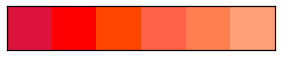

In [55]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

def custom_palette(custom_colors):
    customPalette = sns.set_palette(sns.color_palette(custom_colors))
    sns.palplot(sns.color_palette(custom_colors),size=0.8)
    plt.tick_params(axis='both', labelsize=0, length = 0)

palette = ["#DC143C","#FF0000","#FF4500","#FF6347","#FF7F50","#FFA07A"]
palette2 = sns.diverging_palette(120, 220, n=20)
custom_palette(palette)

custom_theme = Theme({
    "info" : "italic bold cyan",
    "warning": "italic bold magenta",
    "danger": "bold blue"
})

console = Console(theme=custom_theme)

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# Part1: Exploratory Data Analysis

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

## 1.1 Filter Data

### For some columns, since they just represent come metadata information of the comments, they do not contribute much to the later model traning, I decided to drop them.

In [58]:
df = df.drop(columns=['id','parent_id','publication_id','article_id'], axis=1)

## 1.2 Check Missing Values

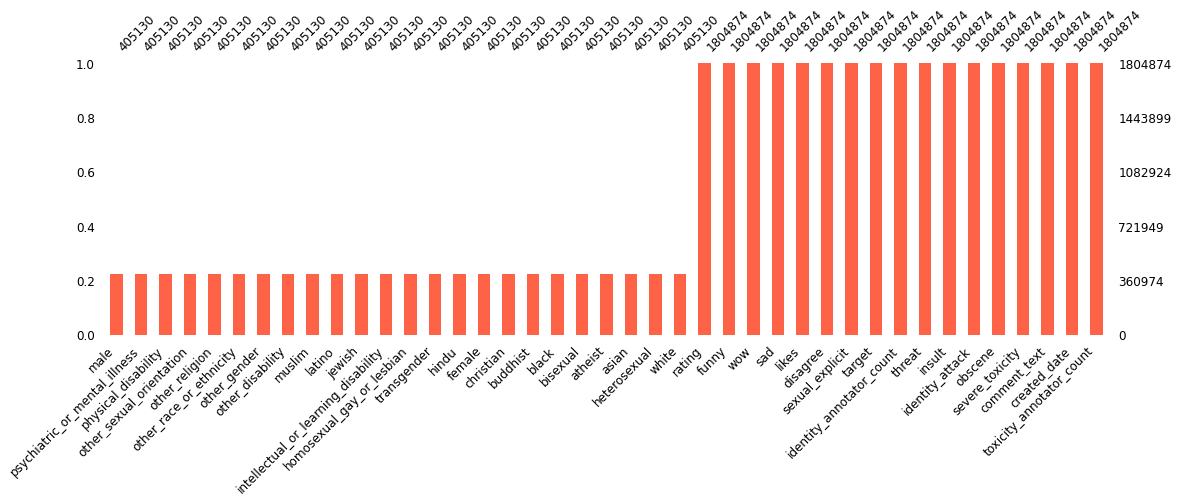

In [59]:
msno.bar(df,color=palette[3], sort="ascending", figsize=(18,5), fontsize=12)
plt.show()

### As we can see, a lot of columns have many missing values. To get an idea of the exact missing ratio, we draw another gradient chart below

In [60]:
missing_count = df.isna().sum()
missing_df = (pd.concat([missing_count.rename('Missing count'),
                     missing_count.div(len(df))
                          .rename('Missing ratio')],axis = 1)
             .loc[missing_count.ne(0)])

#color the background of cells in a dataframe depending on the value of the data in each column 
missing_df.style.background_gradient(cmap="Wistia")

,Missing count,Missing ratio
asian,1399744,0.775536
atheist,1399744,0.775536
bisexual,1399744,0.775536
black,1399744,0.775536
buddhist,1399744,0.775536
christian,1399744,0.775536
female,1399744,0.775536
heterosexual,1399744,0.775536
hindu,1399744,0.775536
homosexual_gay_or_lesbian,1399744,0.775536


### After checking the comment texts with missing identity column values, I found that most of them did not target any specific identities. Thus, for those columns, I decided to replace Nulls with 0

In [63]:
df.iloc[:,7:31]

,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1804869,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1804870,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1804871,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1804872,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
# fill null with 0
df_missing_handled = df.iloc[:,7:31].fillna(value=0)

In [65]:
# Replace the columns in the original dataframe
df.iloc[:, 7:31] = df_missing_handled

### Double check if missing values are all handled

In [66]:
df.isna().sum()

target                                 0
comment_text                           0
severe_toxicity                        0
obscene                                0
identity_attack                        0
insult                                 0
threat                                 0
asian                                  0
atheist                                0
bisexual                               0
black                                  0
buddhist                               0
christian                              0
female                                 0
heterosexual                           0
hindu                                  0
homosexual_gay_or_lesbian              0
intellectual_or_learning_disability    0
jewish                                 0
latino                                 0
male                                   0
muslim                                 0
other_disability                       0
other_gender                           0
other_race_or_et

## 1.3 Summary Statistics

In [61]:
df

,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:41.987077+00,rejected,0,0,0,0,0,0.0,0,4
1,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:42.870083+00,rejected,0,0,0,0,0,0.0,0,4
2,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:45.222647+00,rejected,0,0,0,0,0,0.0,0,4
3,0.000000,Is this something I'll be able to install on m...,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:47.601894+00,rejected,0,0,0,0,0,0.0,0,4
4,0.893617,haha you guys are a bunch of losers.,0.021277,0.000000,0.021277,0.872340,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-09-29 10:50:48.488476+00,rejected,0,0,0,1,0,0.0,4,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1804869,0.000000,"Maybe the tax on ""things"" would be collected w...",0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-11-11 00:55:39.265997+00,approved,0,0,0,0,0,0.0,0,4
1804870,0.000000,What do you call people who STILL think the di...,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-11-11 00:55:56.634498+00,approved,0,0,0,0,0,0.0,0,4
1804871,0.000000,"thank you ,,,right or wrong,,, i am following ...",0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-11-11 00:59:02.840713+00,approved,0,0,0,0,0,0.0,0,4
1804872,0.621212,Anyone who is quoted as having the following e...,0.030303,0.030303,0.045455,0.621212,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-11-11 01:01:10.153692+00,approved,0,0,0,0,0,0.0,0,66


### 1.2.1 For easier handling, we divide the columns into 2 groups: data frame with only numeric values; data frame with only categorical values

In [71]:
# create the numeric dataframe
df_numeric = pd.concat([df.iloc[:, :1],df.iloc[:, 2:31],df.iloc[:, 34:]], axis = 1)

In [68]:
# create the categorical dataframe
df_categoric = df.drop(columns=df_numeric.columns)

### 1.2.2 Summary statistics for numerical data

In [72]:
# statistics of numerical data
df_numeric.astype(float).describe()

,target,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
count,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06
mean,1.030173e-01,4.582099e-03,1.387721e-02,2.263571e-02,8.115273e-02,9.311271e-03,2.685391e-03,7.194128e-04,4.229550e-04,7.719921e-03,3.166063e-04,2.138429e-02,2.865743e-02,7.266002e-04,3.271294e-04,5.748664e-03,2.442398e-04,4.009517e-03,1.375200e-03,2.439631e-02,1.110191e-02,2.739263e-04,1.983881e-04,1.851276e-03,1.517652e-03,3.352774e-04,3.043875e-04,2.712230e-03,1.509225e-03,1.278334e-02,4.420696e-02,1.091173e-01,2.446167e+00,5.843688e-01,6.605974e-03,1.439019e+00,8.784694e+00
std,1.970757e-01,2.286128e-02,6.460419e-02,7.873156e-02,1.760657e-01,4.942218e-02,4.159783e-02,2.381769e-02,1.237983e-02,8.083106e-02,1.466254e-02,1.279360e-01,1.541778e-01,2.174128e-02,1.463412e-02,6.893344e-02,7.608965e-03,5.834757e-02,2.792035e-02,1.347798e-01,9.811484e-02,6.700469e-03,5.627774e-03,2.052887e-02,1.799093e-02,7.310392e-03,8.312833e-03,4.255257e-02,3.282353e-02,1.050397e-01,2.449359e-01,4.555363e-01,4.727924e+00,1.866589e+00,4.529782e-02,1.787041e+01,4.350086e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
75%,1.666667e-01,0.000000e+00,0.000000e+00,0.000000e+00,9.090909e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.0000

### 1.2.3 Summary statistics of categorical data

In [70]:
# statistics of categorical data
df_categoric.astype(str).describe()

,target,comment_text,created_date,rating,funny
count,1804874,1804874,1804874,1804874,1804874
unique,2913,1780823,1804362,2,61
top,0.0,Well said.,2015-10-13 18:40:35.757707+00,approved,0
freq,1264764,184,4,1684758,1549879


## 1.4 Univariate Analysis

### 1.3.1 Univariate Analysis For Numeric Data

/var/folders/4q/v1383t7j6k74mb6zcdqgd4zm0000gn/T/ipykernel_31406/2022509930.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['target'], color=palette[0], shade=True,ax=ax[0])
/var/folders/4q/v1383t7j6k74mb6zcdqgd4zm0000gn/T/ipykernel_31406/2022509930.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['identity_attack'], color=palette[1], shade=True,ax=ax[1])


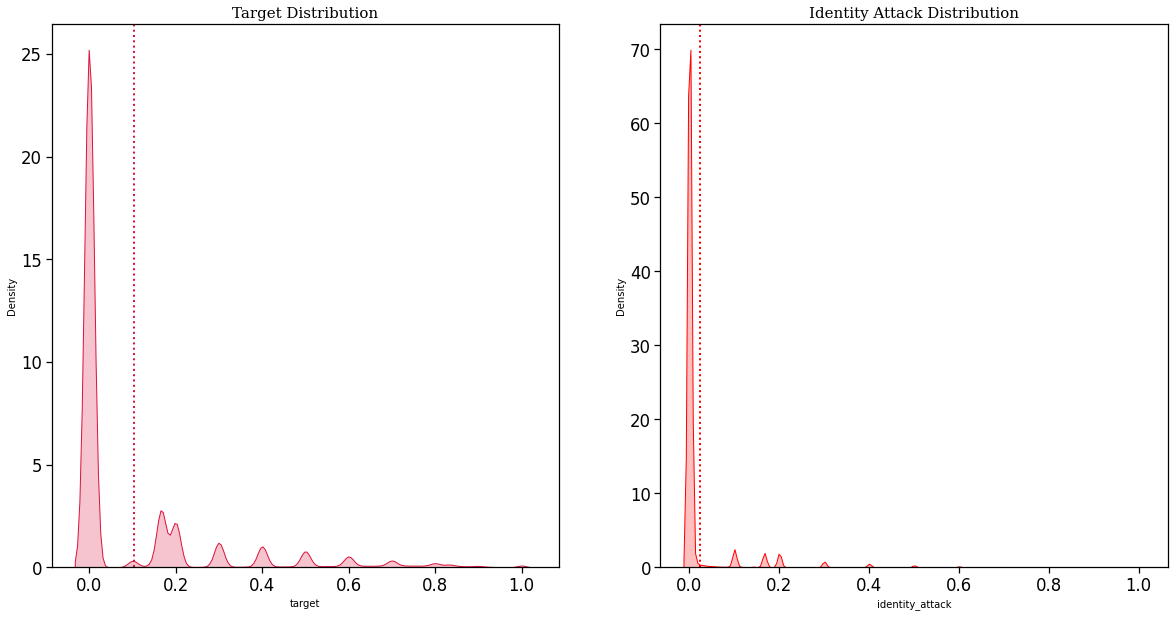

In [17]:
# Distribution plot for Target score and Identity Attack score
fig, ax = plt.subplots(1,2,figsize=(20,10))
sns.kdeplot(df['target'], color=palette[0], shade=True,ax=ax[0])
sns.kdeplot(df['identity_attack'], color=palette[1], shade=True,ax=ax[1])
ax[0].axvline(df['target'].mean(), color=palette[0],linestyle=':', linewidth=2)
ax[1].axvline(df['identity_attack'].mean(), color=palette[1],linestyle=':', linewidth=2)
ax[0].set_title("Target Distribution",font="Serif",fontsize = 15)
ax[1].set_title("Identity Attack Distribution",font="Serif",fontsize = 15)
plt.show()

In [18]:
# plotting histogram + KDE and boxplot for specified column
def plot_distribution(x,c, title=None):
    fig, ax = plt.subplots(1,2,figsize=(12,6))
    sns.distplot(x, ax=ax[0],color=c)
    ax[0].set(xlabel=None)
    ax[0].set_title('Histogram + KDE')
    sns.boxplot(x, ax=ax[1],color=c)
    ax[1].set(xlabel=None)
    ax[1].set_title('Boxplot')
    fig.suptitle(title, fontsize=15)
    plt.tight_layout(pad=3.0)
    plt.show()

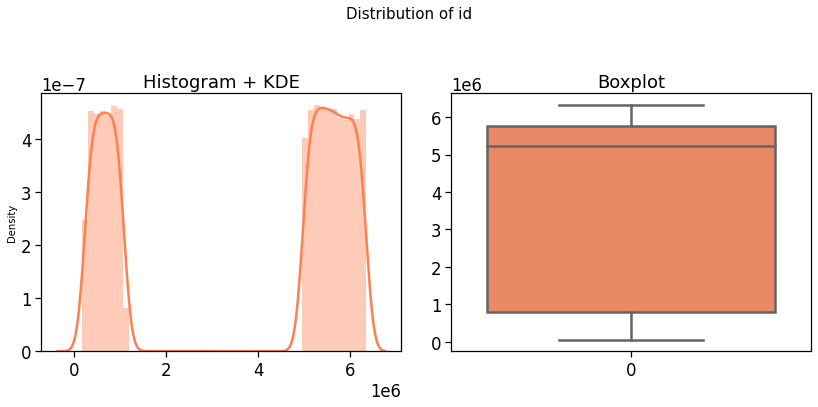

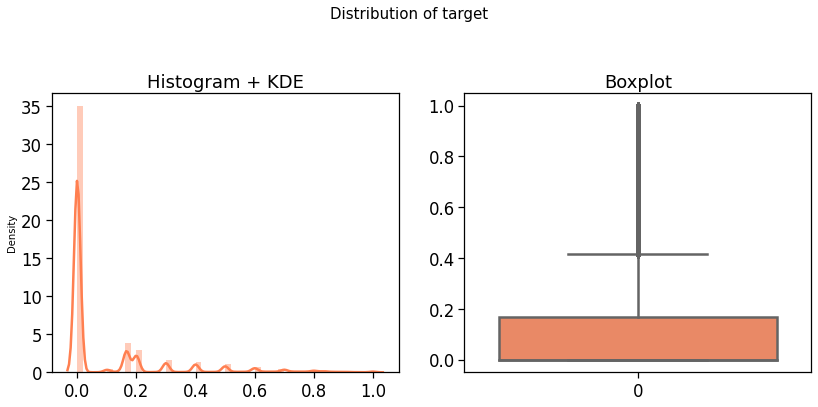

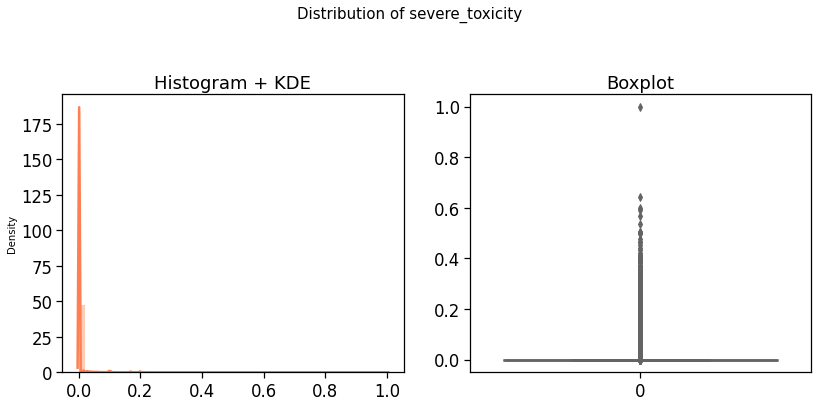

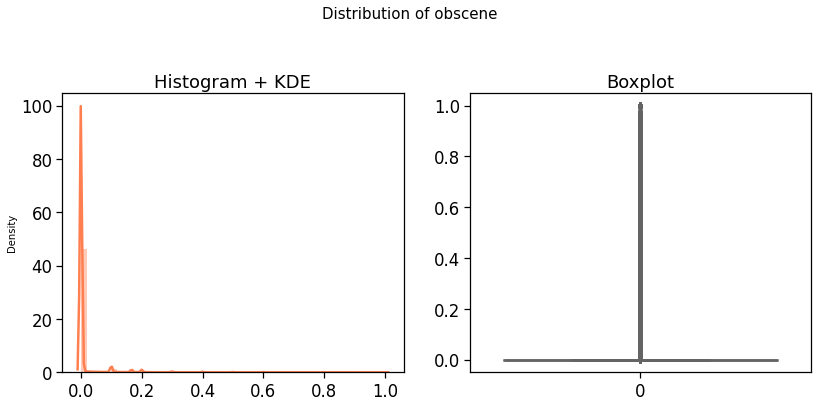

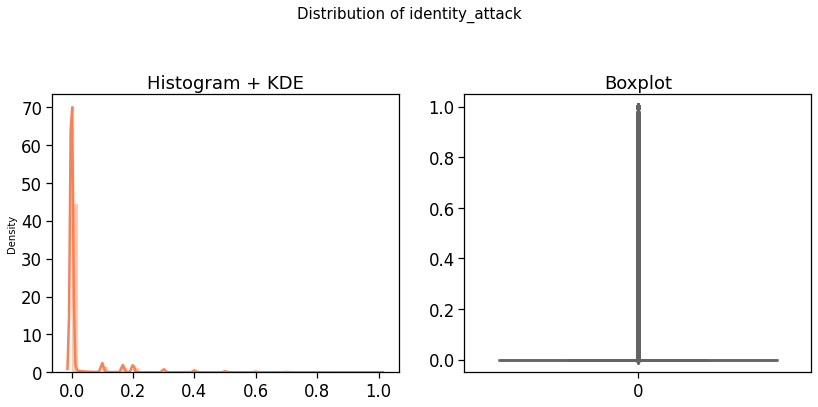

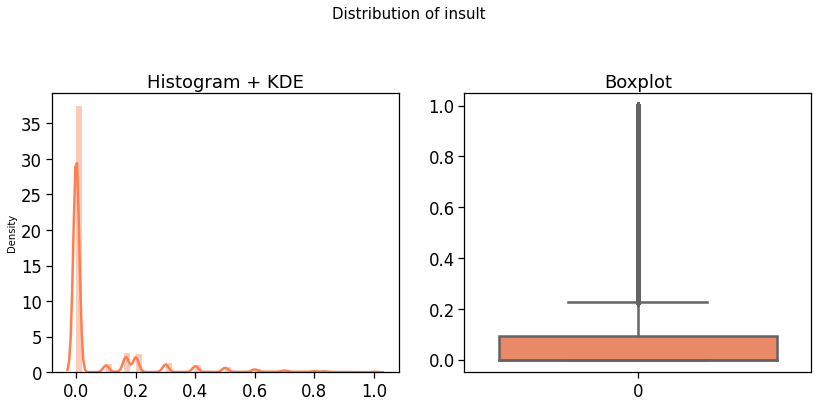

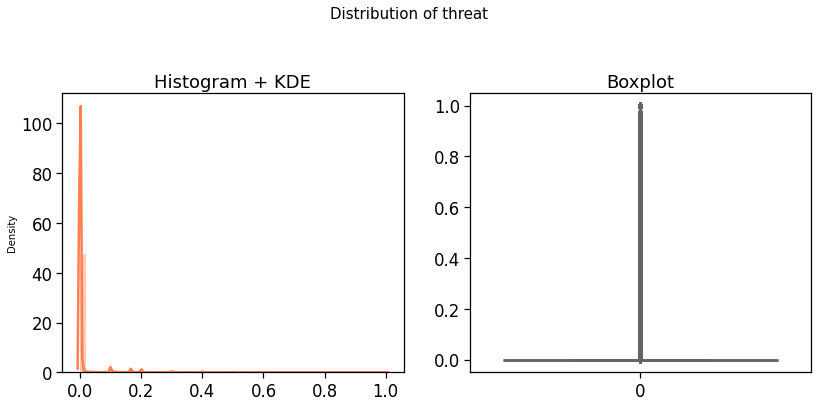

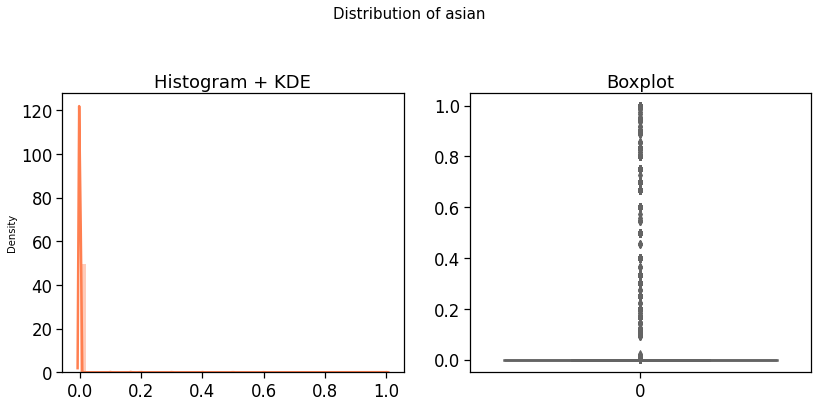

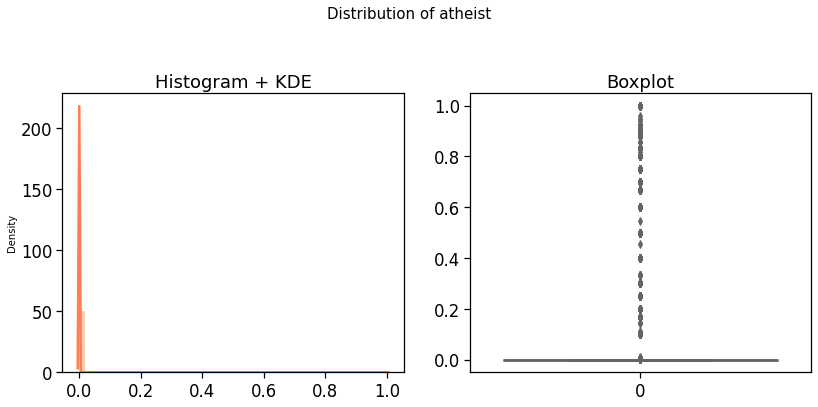

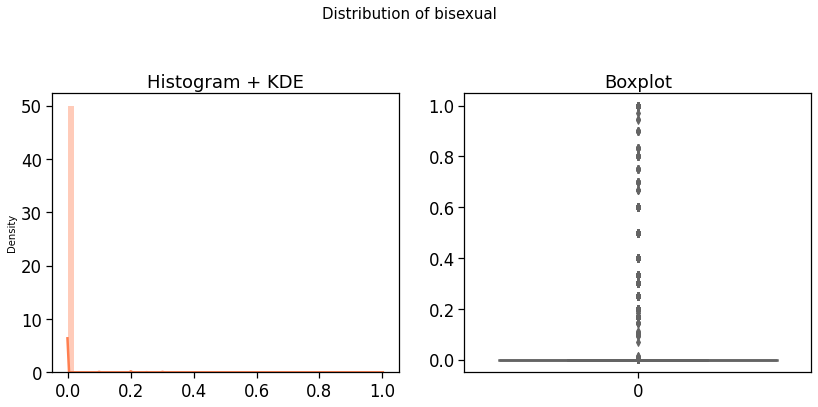

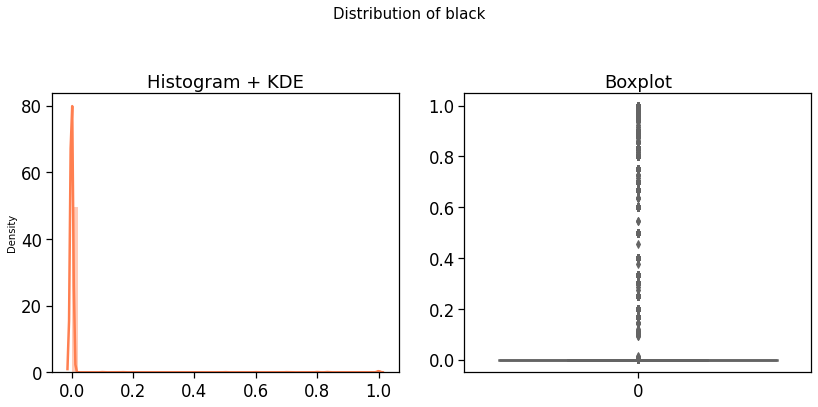

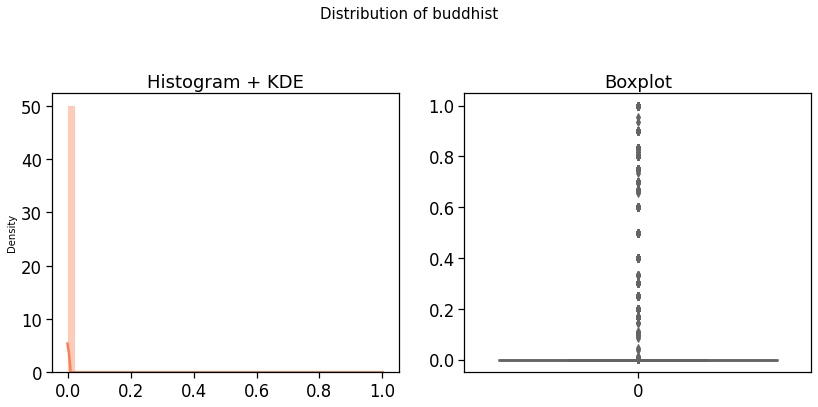

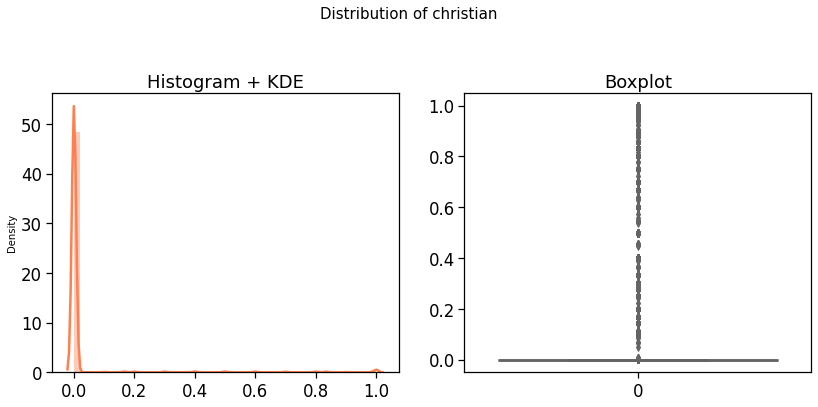

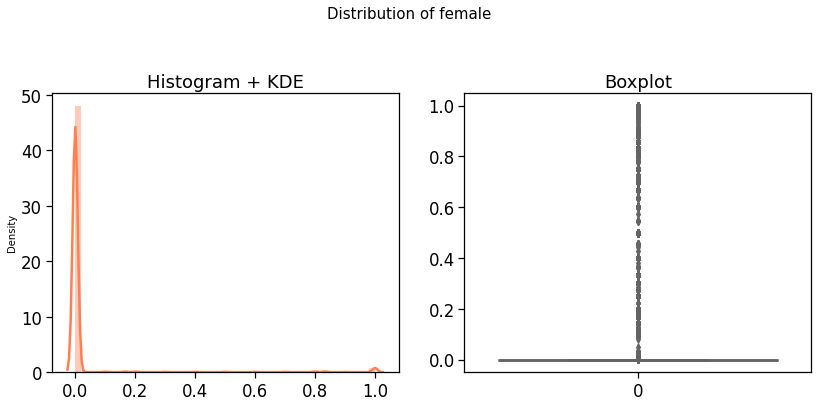

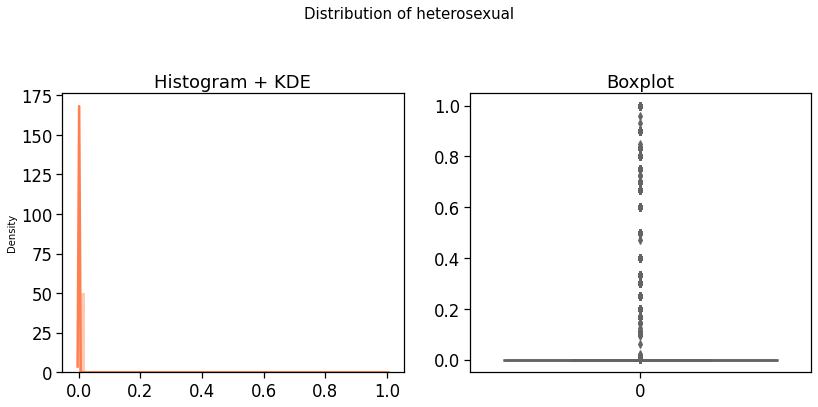

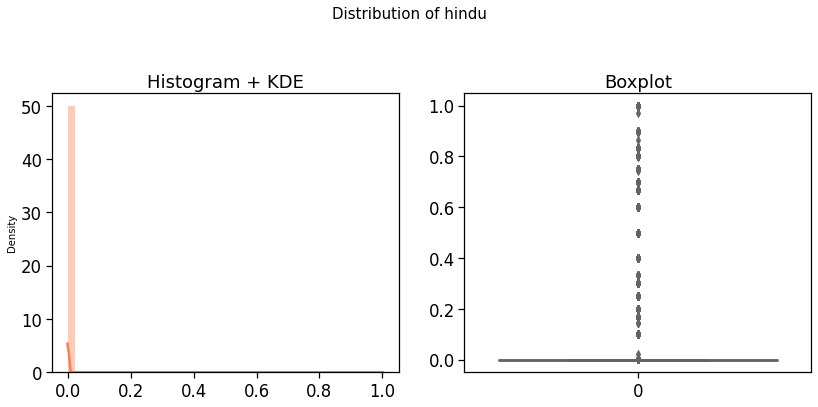

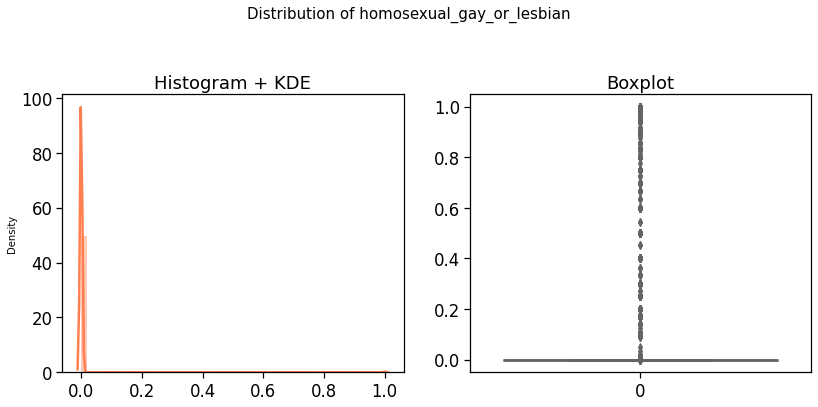

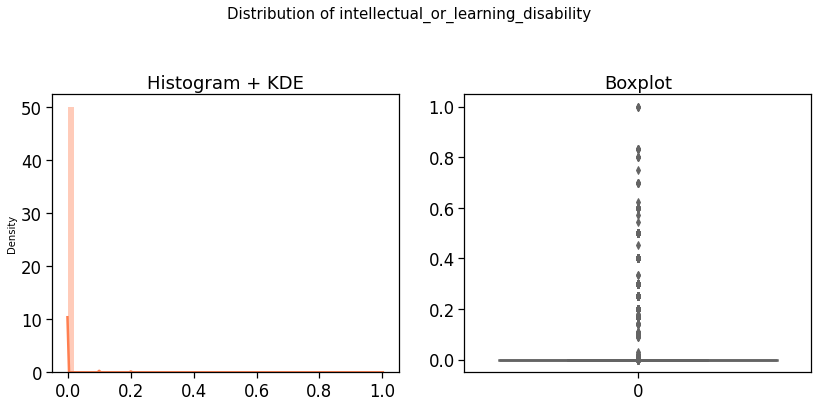

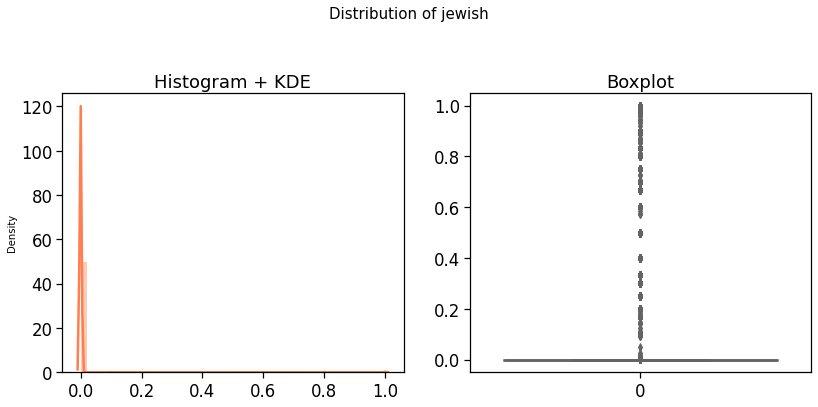

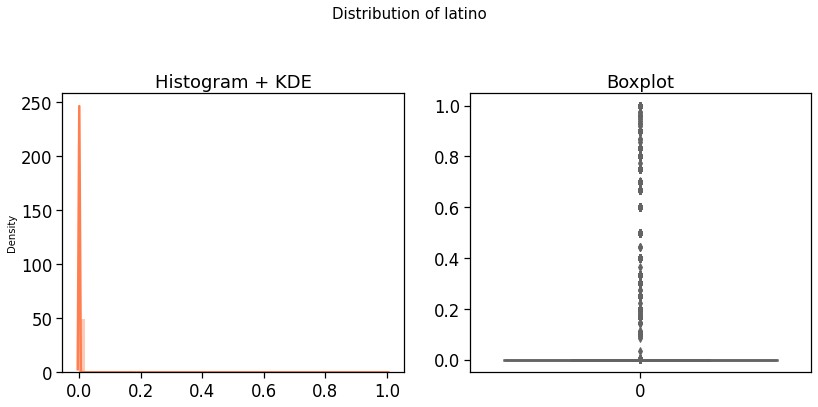

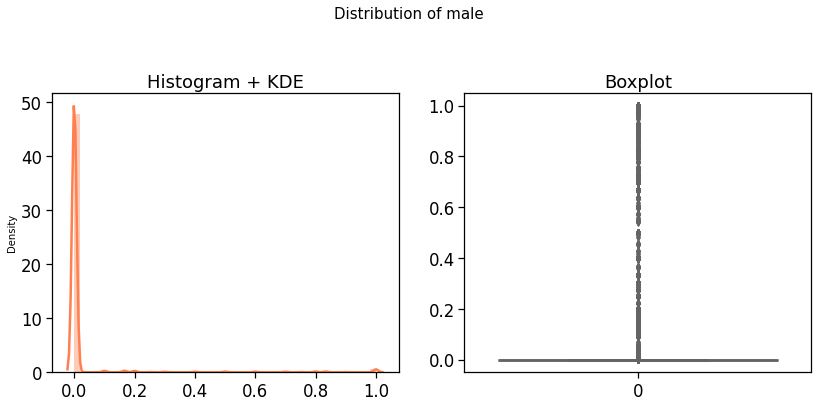

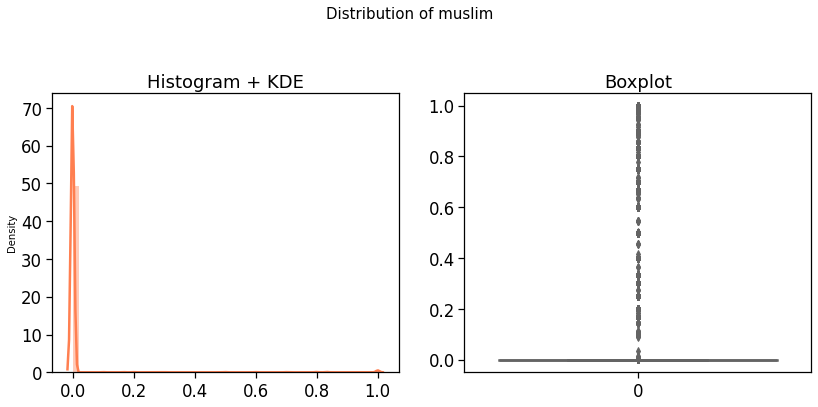

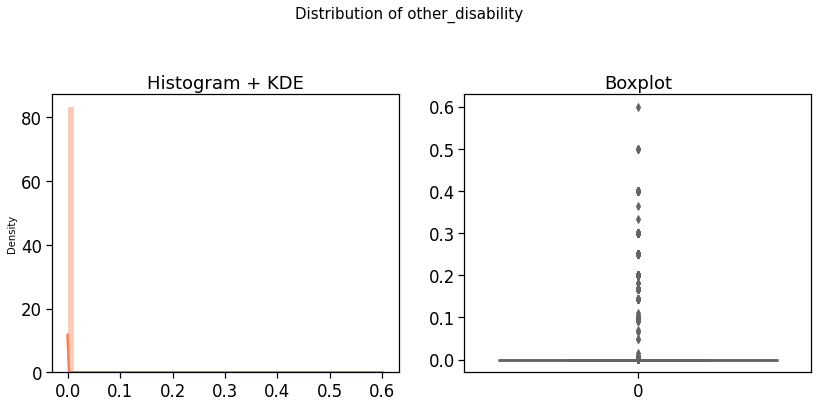

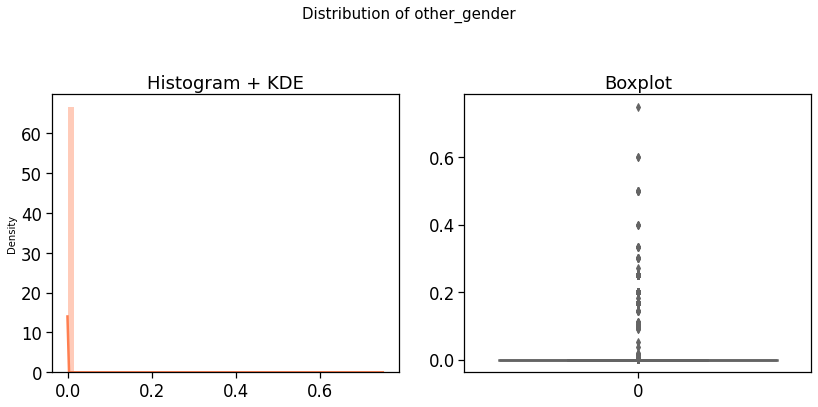

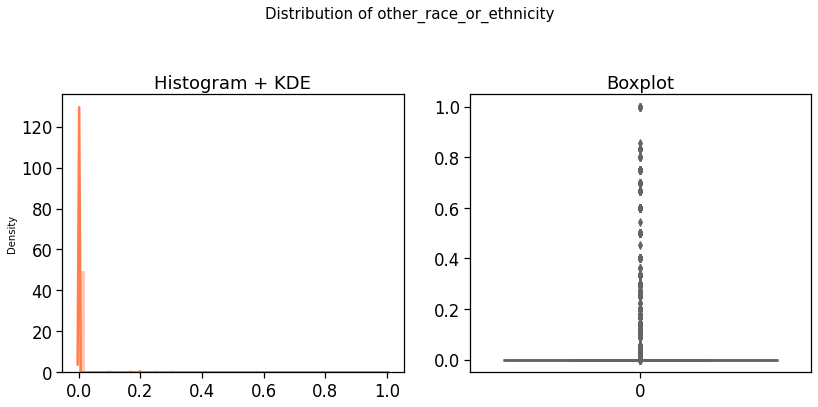

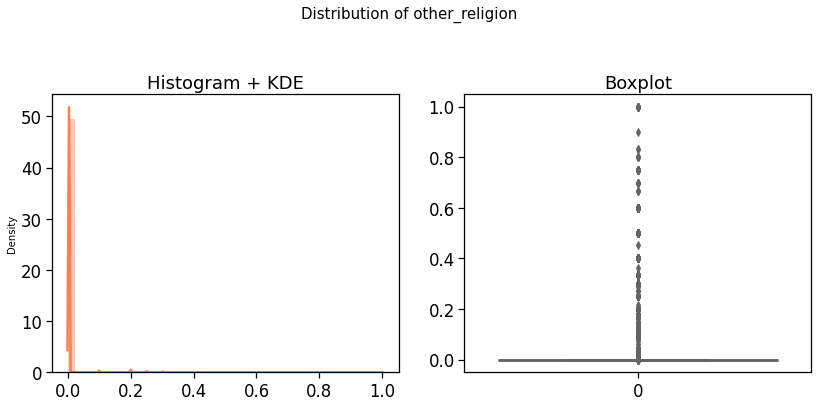

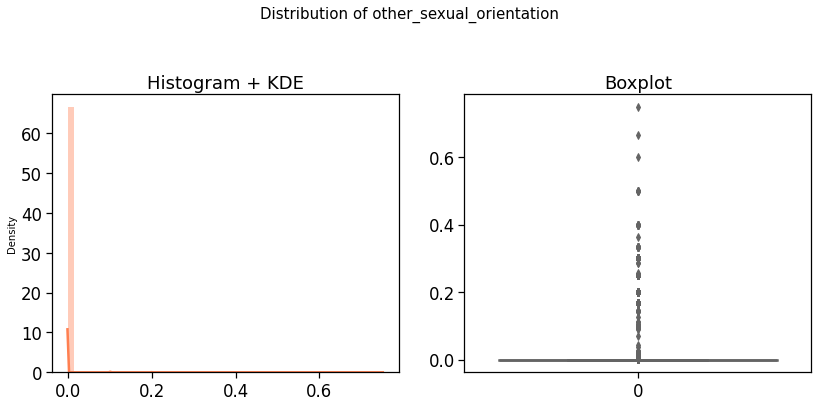

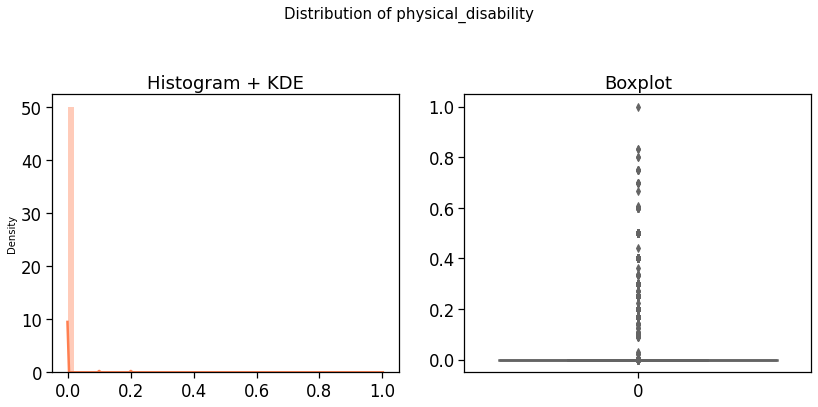

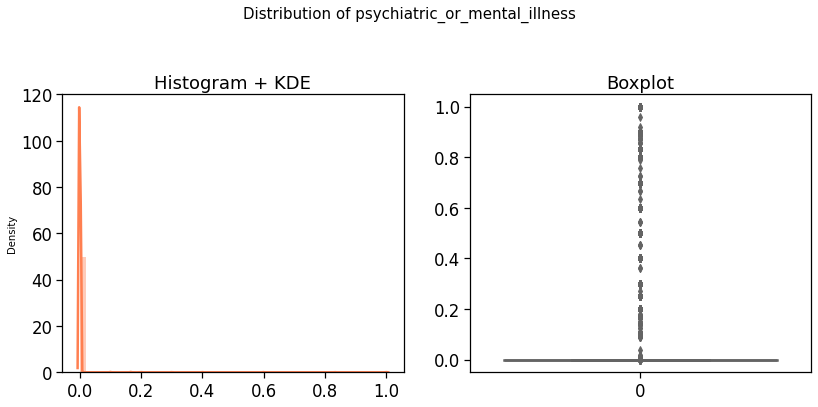

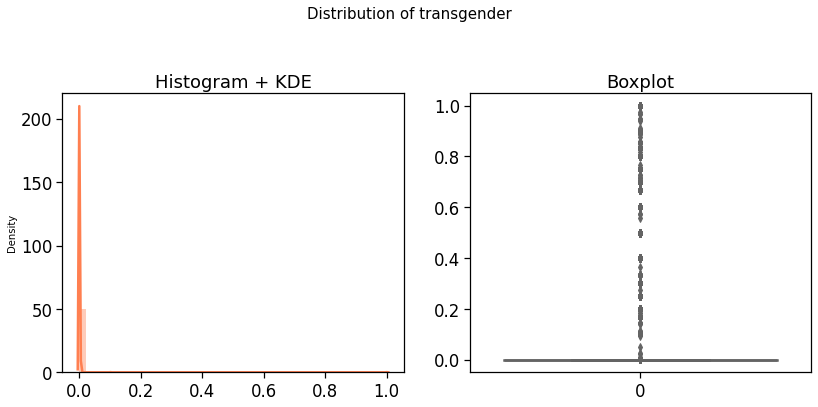

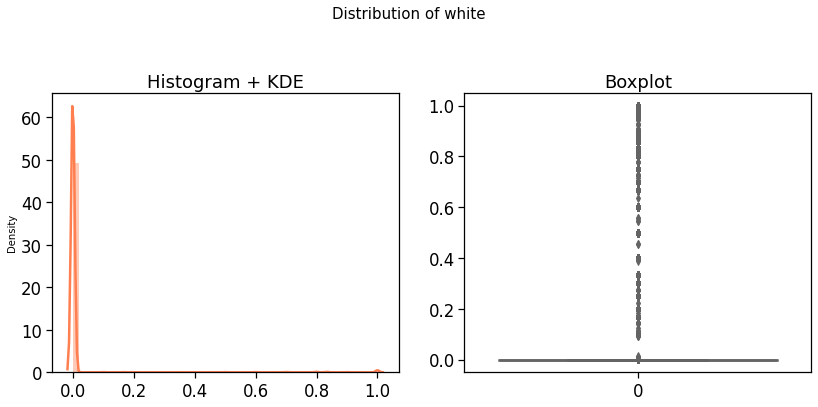

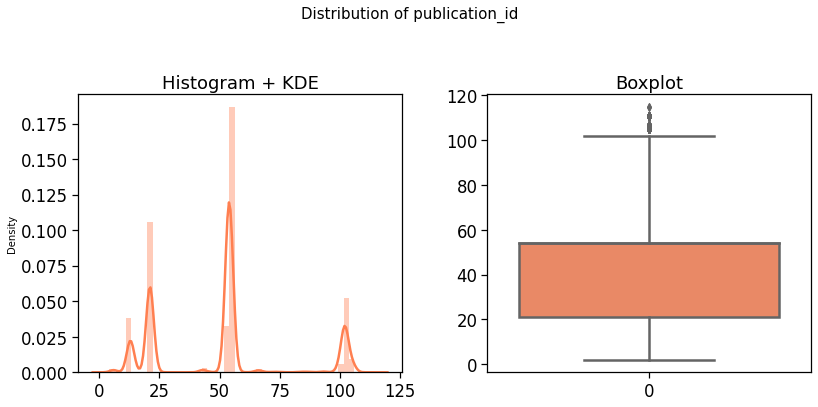

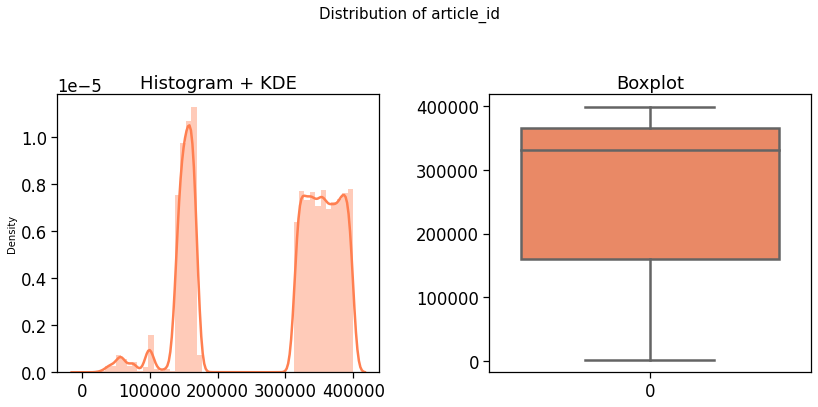

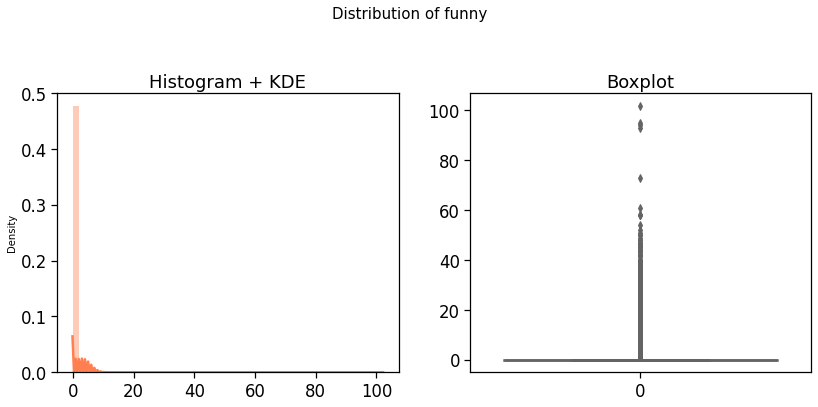

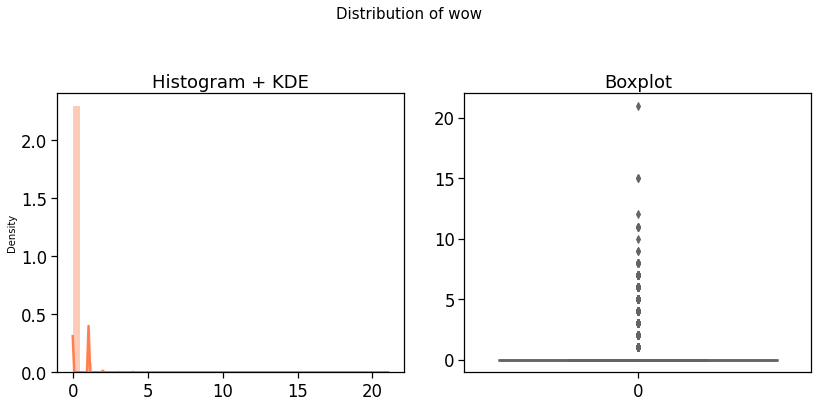

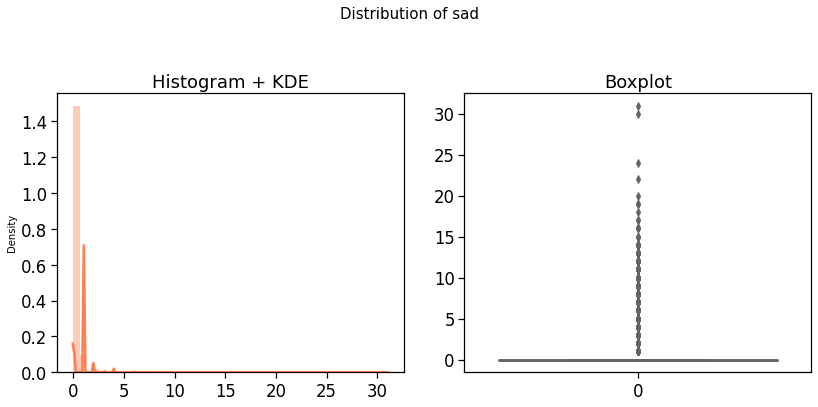

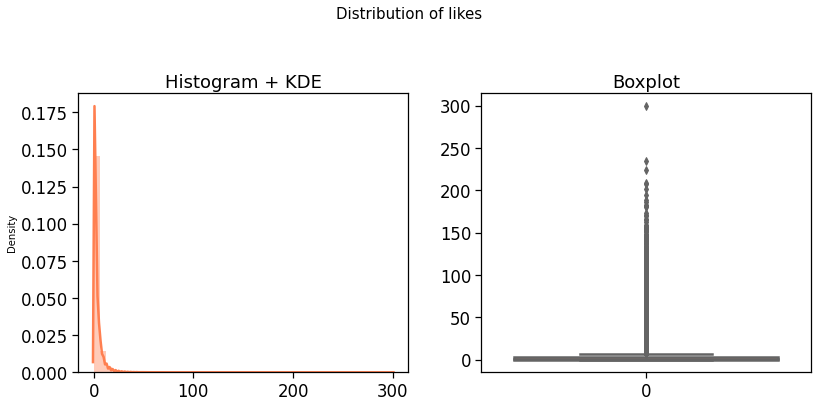

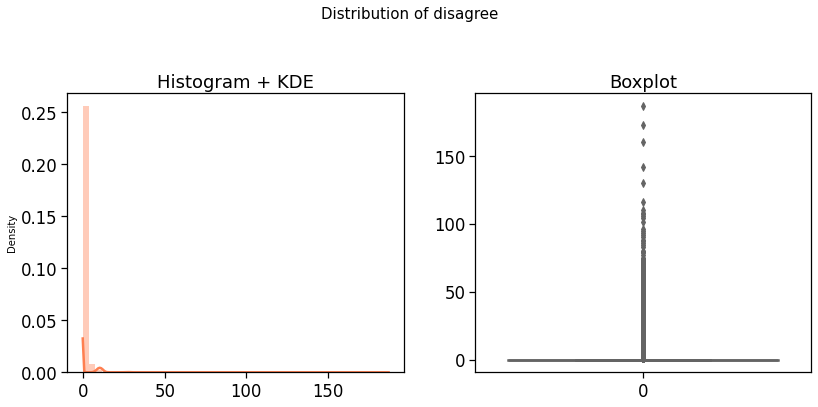

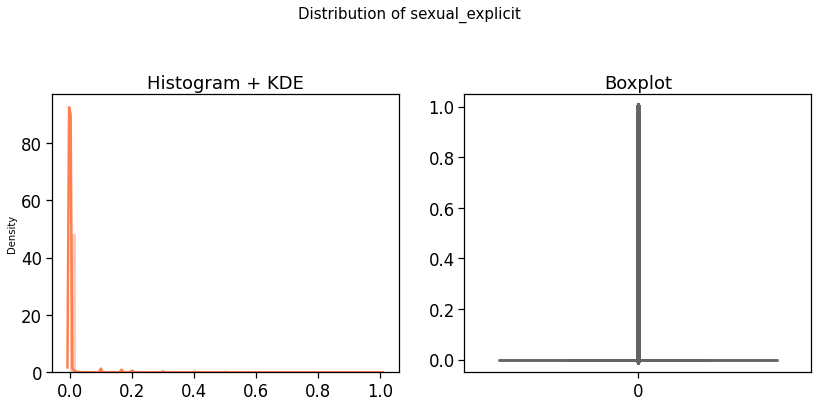

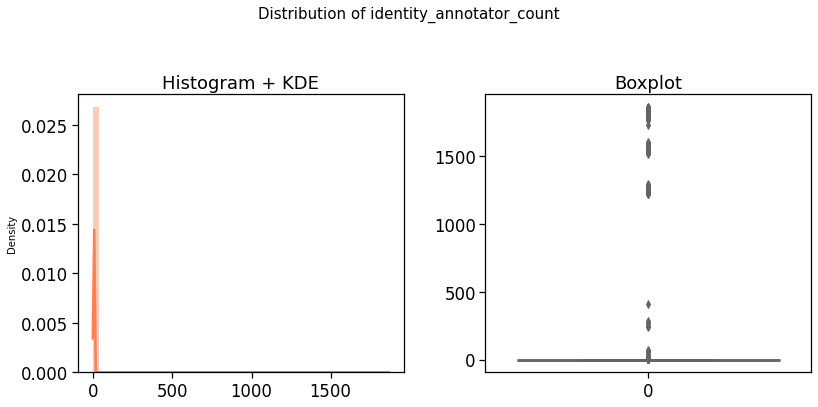

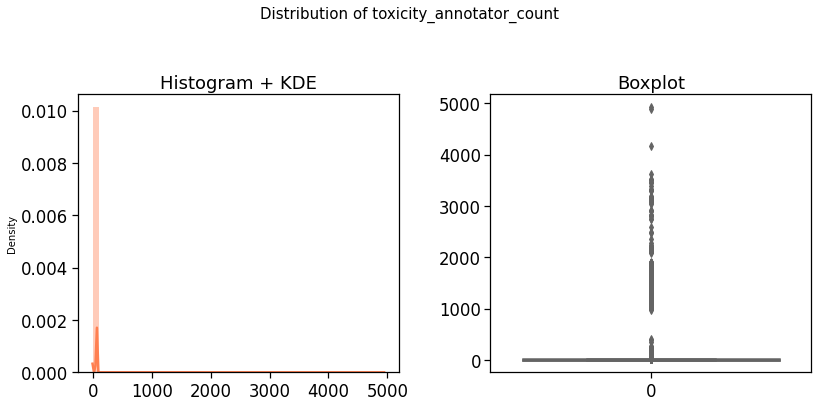

In [19]:
warnings.filterwarnings('ignore')
df_numeric = df_numeric.reset_index(drop=True)
for name in list(df_numeric.columns):
    plot_distribution(df_numeric[name],palette[4], title="Distribution of " + name)

### As we can tell from the histogram here, a lot of columns have 0 value for most records and the rest values appear to be outliers, however, since most identity columns like these have each separate value representing a certain evaluation of the toxicity for each comment text, we don't think it makes sense to replace these outliers with median or mean. Treating outliers in this case can cause severe biase in later model training. 

### 1.3.2 Univariate Analysis For Categorical Data

### We only have 3 columns as categorical data, one of them is text, one of them is date. It's not quite helpful to conduct the univariate analysis on these two columns because almost each record has a unique data. Thus, we will only conduct the univariate analysis on rating column

Boxplot and histogram for Rating


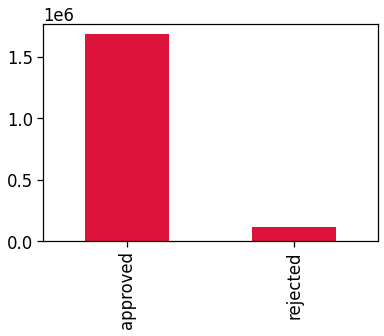

In [20]:
# Columns graph for rating column
%matplotlib inline

print('Boxplot and histogram for Rating')
df_categoric['rating'].value_counts().plot(kind='bar')
plt.show()

### Most comment texts are approved and only a small amount of comments are rejected.

## 1.5 Bivariate Analysis

### 1.4.1 correlation matrix

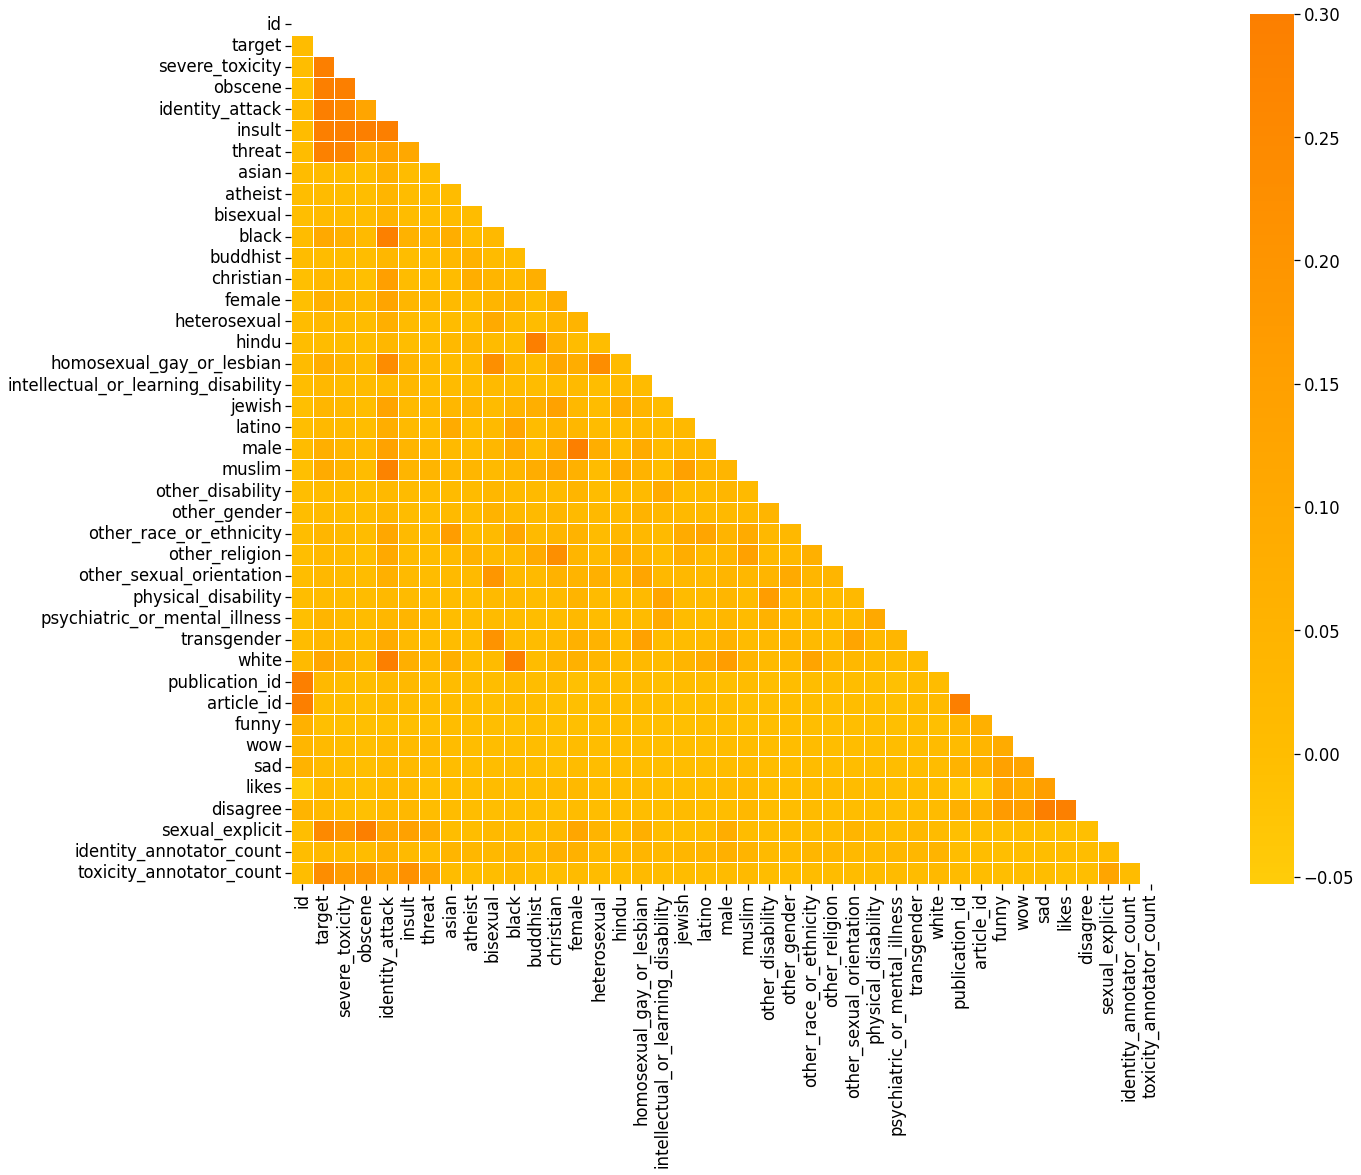

In [21]:
# generating a correlation heatmap
plt.figure(figsize=(32,16))

#calculate the correlation matrix for numerical columns
corr = df_numeric.astype(float).corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='Wistia', vmax=.3, center=0,
            square=True, linewidths=.5)
plt.show()

### Based on the above correlation matrix, I will pick out some highly mutual correlative variables to see the relationship in a more detailed way

In [22]:
def scatter_plot_with_trendline(data_file, x_col, y_col,dot_color,trend_color):
    
    # Create plot and adjust font size and colors
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.scatter(df[x_col], df[y_col], c=dot_color)
    ax.set_xlabel(x_col, fontsize=16)
    ax.set_ylabel(y_col, fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=14)
    # Add title
    ax.set_title('Scatter plot of {} vs {} with trend line'.format(x_col, y_col), fontsize=18)

    # Add trend line
    slope, intercept, r_value, p_value, std_err = linregress(df[x_col], df[y_col])
    x_range = np.array([df[x_col].min(), df[x_col].max()])
    x = np.linspace(x_range[0], x_range[1], 100)
    y = slope * x + intercept
    y_range = ax.get_ylim()
    x_range = (y_range[0] - intercept) / slope, (y_range[1] - intercept) / slope
    x = np.clip(x, *x_range)
    y = slope * x + intercept
    ax.plot(x, y, color=trend_color, linewidth=2)

    plt.show()

### 1.4.2 Relationships between specific type of toxicity vs target

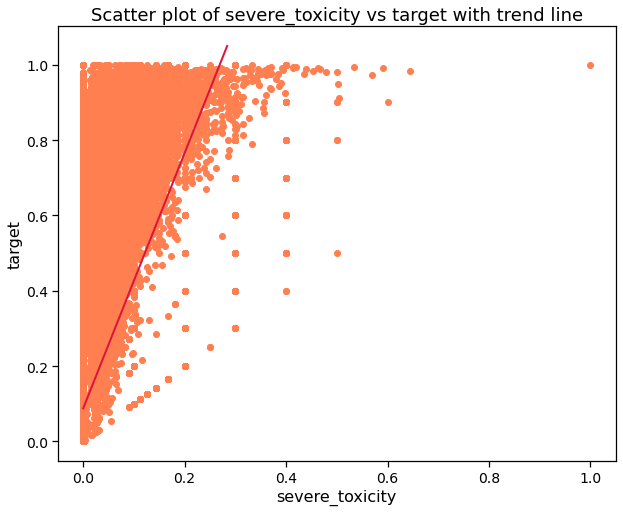

In [23]:
scatter_plot_with_trendline(df,'severe_toxicity','target',palette[4],palette[0])

### As shown above, in general, as severe_toxicity score goes up, the target score of a comment goes up. These 2 variables are positively correlative.

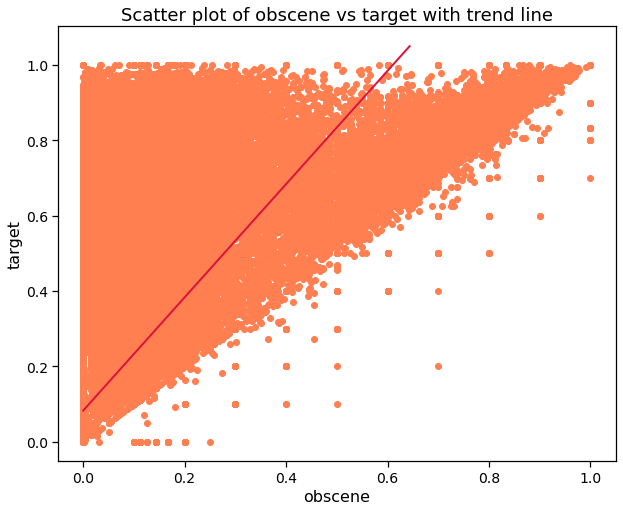

In [24]:
scatter_plot_with_trendline(df,'obscene','target',palette[4],palette[0])

### As shown above, in general, as obscene score goes up, the target score of a comment goes up. These 2 variables are positively correlative.

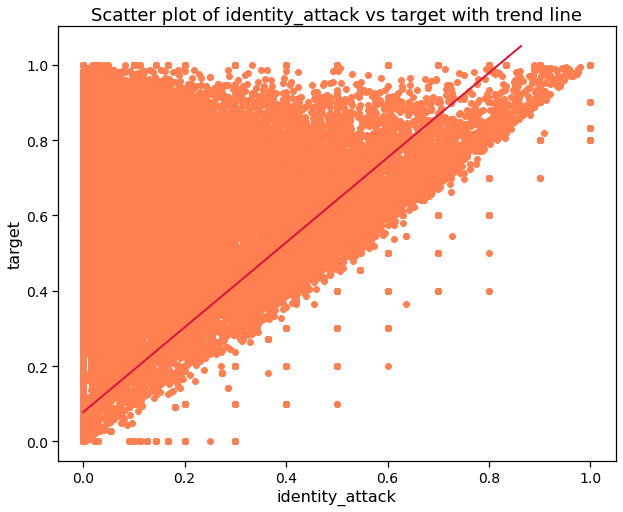

In [25]:
scatter_plot_with_trendline(df,'identity_attack','target',palette[4],palette[0])

### As shown above, in general, as identity_attack score goes up, the target score of a comment goes up. These 2 variables are positively correlative.

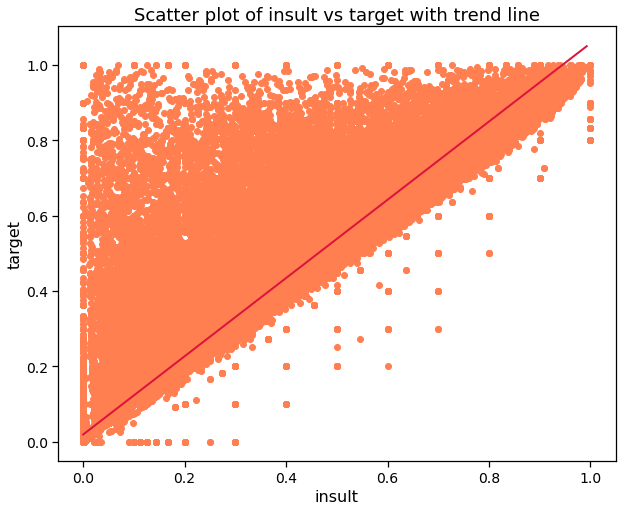

In [26]:
scatter_plot_with_trendline(df,'insult','target',palette[4],palette[0])

### As shown above, in general, as insult score goes up, the target score of a comment goes up. These 2 variables are positively correlative.

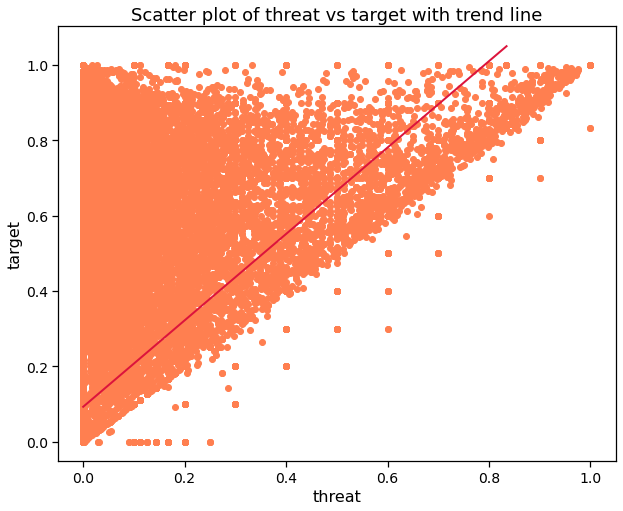

In [27]:
scatter_plot_with_trendline(df,'threat','target',palette[4],palette[0])

### As shown above, in general, as threat score goes up, the target score of a comment goes up. These 2 variables are positively correlative.

### 1.4.3 Relationships between several partterns of attacks: race, gender, religion..

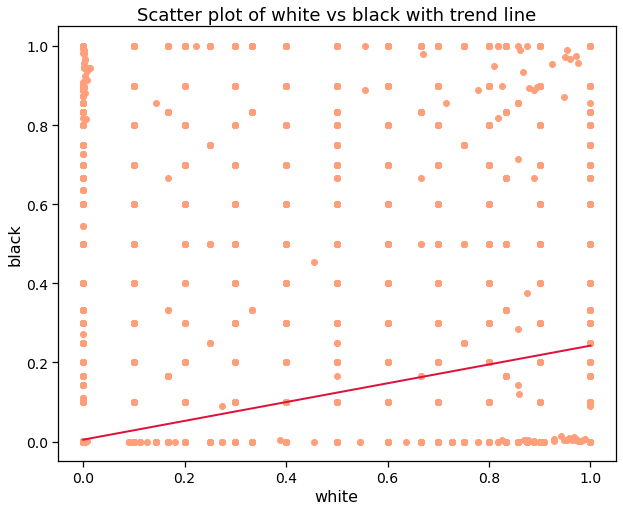

In [28]:
scatter_plot_with_trendline(df,'white','black',palette[5],palette[0])

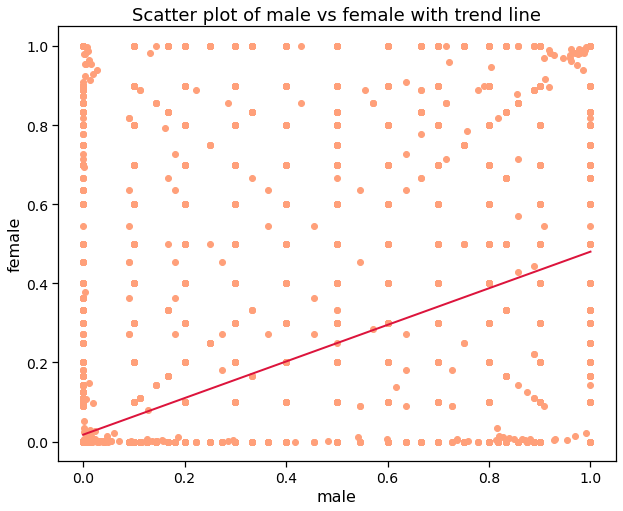

In [29]:
scatter_plot_with_trendline(df,'male','female',palette[5],palette[0])

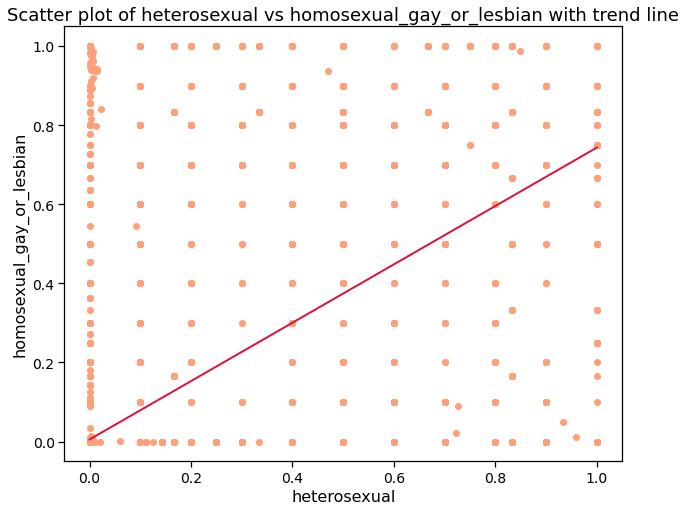

In [30]:
scatter_plot_with_trendline(df,'heterosexual','homosexual_gay_or_lesbian',palette[5],palette[0])

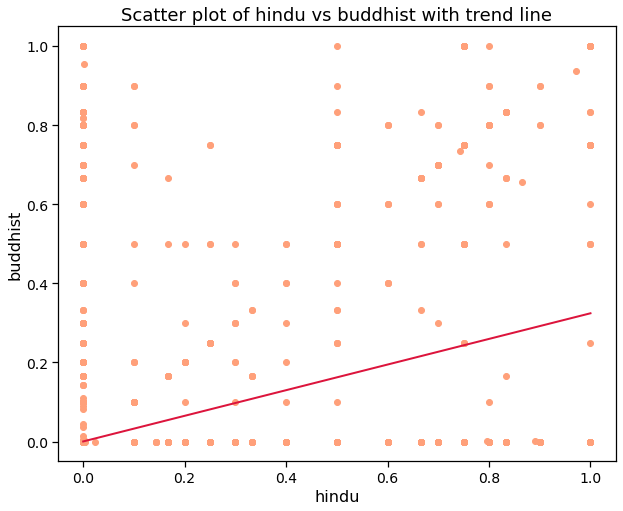

In [31]:
scatter_plot_with_trendline(df,'hindu','buddhist',palette[5],palette[0])

### 1.4.4 Target & specific type of toxicity over time

In [32]:
# convert timestamp column to datetime dtype
df['created_date'] = pd.to_datetime(df['created_date'])

# extract date component and overwrite timestamp column
df['created_date'] = df['created_date'].dt.date

# sort dataframe based on created_date column
df = df.sort_values('created_date')

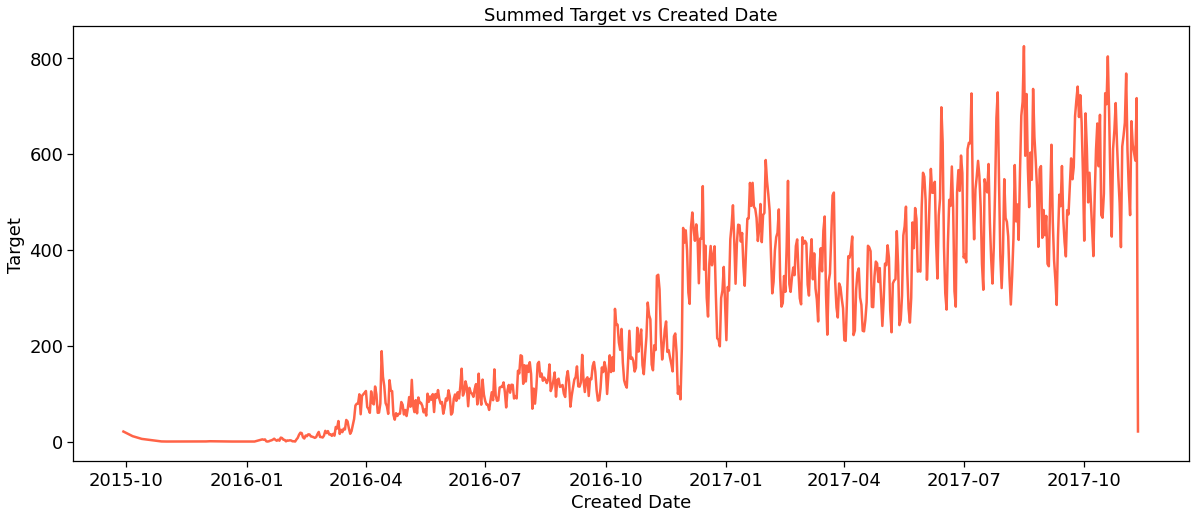

In [33]:
# sum target column scores grouped by created_date column
df_grouped = df.groupby('created_date').sum()

# set font size, chart size, and color
font_size = 18
fig_size = (20, 8)
font_color = "black"

# create line chart with adjusted font size, chart size, and color
plt.figure(figsize=fig_size)
plt.plot(df_grouped.index, df_grouped['target'], color=palette[3])

# set axis labels with adjusted font size and color
plt.xlabel('Created Date', fontsize=font_size)
plt.ylabel('Target', fontsize=font_size)

# set title with adjusted font size and color
plt.title('Summed Target vs Created Date', fontsize=font_size, color=font_color)

# set tick parameters with adjusted font size and color
plt.xticks(fontsize=font_size, color=font_color)
plt.yticks(fontsize=font_size, color=font_color)

# show plot
plt.show()

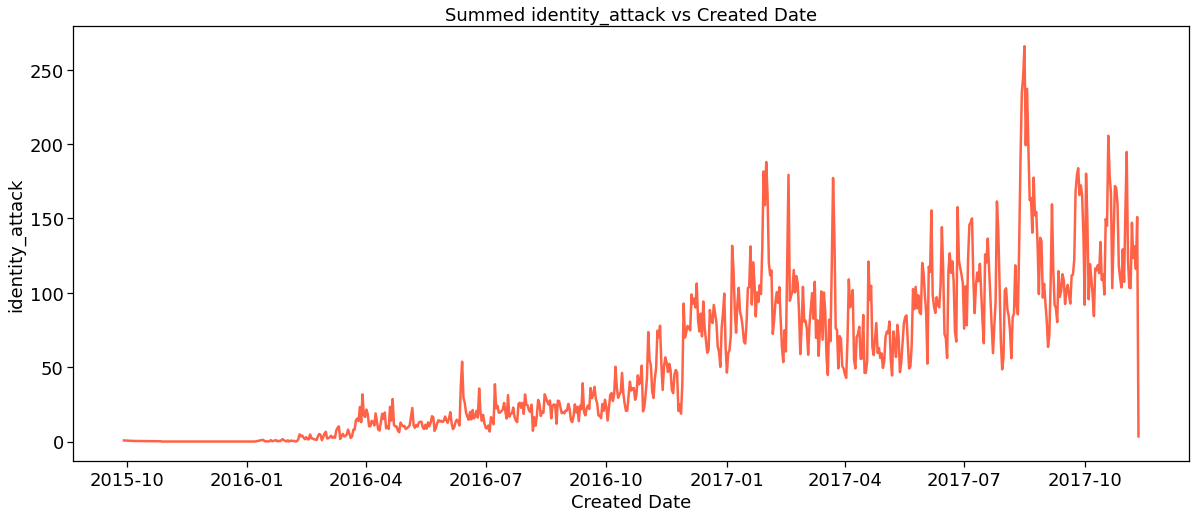

In [34]:
# sum target column scores grouped by created_date column
df_grouped = df.groupby('created_date').sum()

# set font size, chart size, and color
font_size = 18
fig_size = (20, 8)
font_color = "black"

# create line chart with adjusted font size, chart size, and color
plt.figure(figsize=fig_size)
plt.plot(df_grouped.index, df_grouped['identity_attack'], color=palette[3])

# set axis labels with adjusted font size and color
plt.xlabel('Created Date', fontsize=font_size)
plt.ylabel('identity_attack', fontsize=font_size)

# set title with adjusted font size and color
plt.title('Summed identity_attack vs Created Date', fontsize=font_size, color=font_color)

# set tick parameters with adjusted font size and color
plt.xticks(fontsize=font_size, color=font_color)
plt.yticks(fontsize=font_size, color=font_color)

# show plot
plt.show()

### We noticed during August 2017, the target and identity attack score reached peak. Thus, we decided to find out the max score date to see what happened.

In [35]:
# sum the target column scores grouped by the created_date column
summed_df = df.groupby('created_date')['target'].sum().reset_index()

# find the max target score and corresponding created_date
max_target_score = summed_df['target'].max()
max_target_created_date = summed_df.loc[summed_df['target'] == max_target_score, 'created_date'].iloc[0]

print("Max target score: ", max_target_score)
print("Corresponding created date: ", max_target_created_date)

Max target score:  824.1610961079017
Corresponding created date:  2017-08-16


In [36]:
# filter for rows with created_date = "2017-08-16" and target != 0 or identity_attack != 0
mask = (df['created_date'] == pd.to_datetime('2017-08-16', format='%Y-%m-%d')) & \
       ((df['target'] != 0) | (df['identity_attack'] != 0))
filtered_df = df.loc[mask]

# get comment_text column data from filtered dataframe
comment_text_data = filtered_df['comment_text']

In [37]:
comment_text_data

1362502    The Clinton Democrats, SJWs, antiracist Tolera...
1362498    "Reading comprehension fail."\n\nIndeed.\n\nI ...
1362497    It was fairly clear that Gardner's strategy wa...
1362496    Harper also ran a candidate that would come to...
1362493    So many buzzwords, do you actually read the ca...
                                 ...                        
1360416    Actions speak stronger than words. Too many in...
1360415    These two gentlemen have been rejected by the ...
1360414    I fail to detect the bigotry or hatred in MAAA...
1360412    . the sack of garbage trump goes ahead and tot...
1360411    . the sack of garbage trump goes ahead and tot...
Name: comment_text, Length: 2327, dtype: object

In [38]:
# convert comment_text column to lowercase
comment_text_data = comment_text_data.str.lower()

# filter for rows mentioning "trump", "immigration", or related words
keywords = ['trump', 'immigration','raise','biased']  # add any other related words here
mask = comment_text_data.str.contains('|'.join(keywords))
comment_text_data[mask].count()

567

### According to news in August 2017, Donald Trump released a new plan for immigration in US which would curtail almost half of US immigrants. Many critics said this new policy was highly biased. With a rough keywords match on the comment text in the peak identity_attack day, we found 567 comments speaking of this issue. This can be part of the reaons we see a peak score during that period.

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# Part2: Word Level Analysis Of Comment Text

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

## 2.1 Preprocess comment data

### To do the word level analysis, it's very important to preprocess the comment text data.

In [39]:
comment1 = df['comment_text'].min()
console.print("Before preprocessing: ",style="info")
console.print(comment1,style='warning')

e = re.sub("[^a-zA-Z]", " ", comment1)
e = e.lower()
        
e = nltk.word_tokenize(e)
        
e = [word for word in e if not word in set(stopwords.words("english"))]
        
lemma = nltk.WordNetLemmatizer()
e = [lemma.lemmatize(word) for word in e]
e=" ".join(e)
console.print("After preprocessing: ",style="info")
console.print(e,style='warning')

Before preprocessing: 

Canada is north of the USA border,  its colder in Canada.

After preprocessing: 

canada north usa border colder canada

In [40]:
#====== Preprocessing function ======
def preprocess(data):
    comment_processed=[]
    for e in data['comment_text']:
        
        # find alphabets
        e = re.sub("[^a-zA-Z]", " ", e)
        
        # convert to lower case
        e = e.lower()
        
        # tokenize words
        e = nltk.word_tokenize(e)
        
        # remove stopwords
        e = [word for word in e if not word in set(stopwords.words("english"))]
        
        # lemmatization
        lemma = nltk.WordNetLemmatizer()
        e = [lemma.lemmatize(word) for word in e]
        e=" ".join(e)
        
        comment_processed.append(e)
        if len(comment_processed) % 10000.0 == 0:
            print("update: " +str(len(comment_processed)))
        
    return comment_processed

In [ ]:
df["comment_preprocessed"] = preprocess(df)

### I tried the prerpocessing here and it turned out to be too slow: 10000 records took 5 mins to run. Thus, I did the preprocessing on Kaggle Notebook with a faster ratio and then saved the new csv file to keep working on the word level analysis 

In [4]:
df_preprocessed = pd.read_csv(os.path.join(Config.DATA_DIR, "train_comment_preprocessed.csv"), dtype={"comment_text": str})

## 2.2 Top unigrams & bigrams distribution

In [6]:
def get_top_n_words(corpus, n=None):
    vec = CV().fit(corpus)
    print("position 1")# to show a process update while running since with 1.8 million records, it's slow
    bag_of_words = vec.transform(corpus)
    print("position 2")# to show a process update while running since with 1.8 million records, it's slow
    sum_words = bag_of_words.sum(axis=0) 
    print("position 3")# to show a process update while running since with 1.8 million records, it's slow
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    print("position 4")# to show a process update while running since with 1.8 million records, it's slow
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    print("position 5")# to show a process update while running since with 1.8 million records, it's slow
    return words_freq[:n]

In [7]:
def get_top_n_bigram(corpus, n=None):
    vec = CV(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def plot_bt(x,w,p):
    common_words = x(df_preprocessed["comment_preprocessed"].apply(lambda x: np.str_(x)), 20)
    common_words_df = DataFrame (common_words,columns=['word','freq'])
    plt.figure(figsize=(16,8))
    sns.barplot(x='freq', y='word', data=common_words_df,facecolor=(0, 0, 0, 0),linewidth=3,edgecolor=sns.color_palette(p,20))
    plt.title("Top 20 "+ w,font='Serif', fontsize=16)
    plt.xlabel("Frequency", fontsize=14)
    plt.yticks(fontsize=13)
    plt.xticks(rotation=45, fontsize=13)
    plt.ylabel("");
    return common_words_df

### 2.2.1 On all comments

In [10]:
common_words = get_top_n_words(df_preprocessed["comment_preprocessed"].apply(lambda x: np.str_(x)), 20)

position 1
position 2
position 3
position 4
position 5


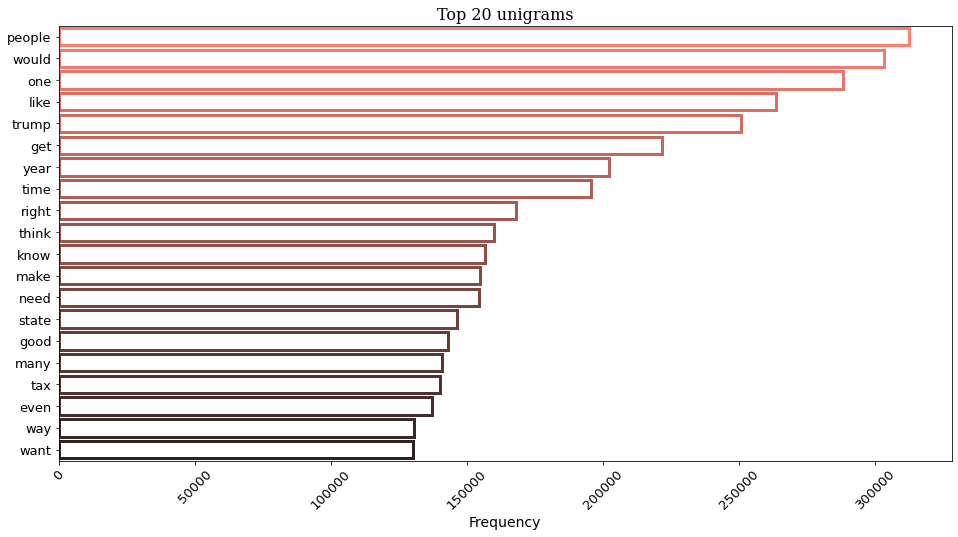

In [12]:
common_words_df1 = DataFrame(common_words,columns=['word','freq'])
plt.figure(figsize=(16, 8))
ax = sns.barplot(x='freq', y='word', data=common_words_df1,facecolor=(0, 0, 0, 0),linewidth=3,edgecolor=sns.color_palette("dark:salmon_r",20))

plt.title("Top 20 unigrams",font='Serif', fontsize=16)
plt.xlabel("Frequency", fontsize=14)
plt.yticks(fontsize=13)
plt.xticks(rotation=45, fontsize=13)
plt.ylabel("");

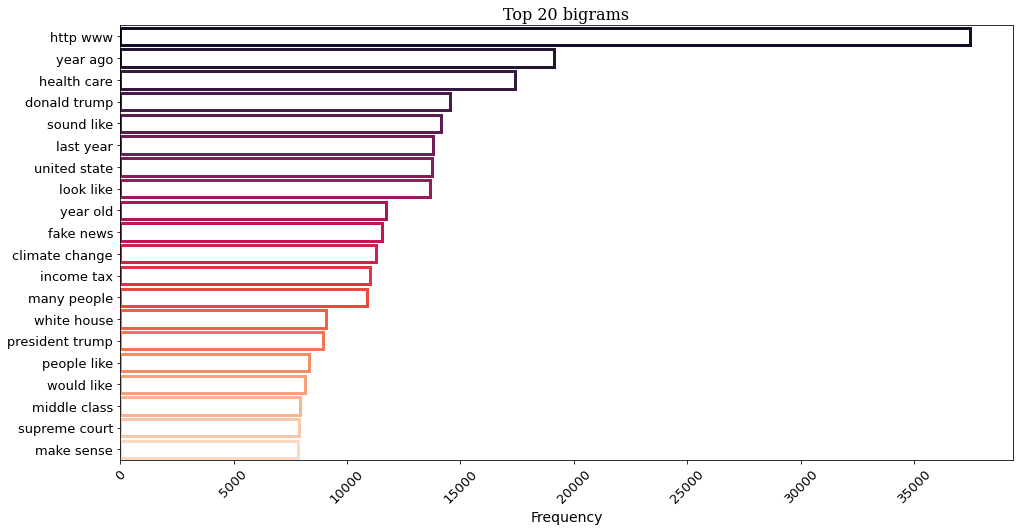

In [13]:
common_words_df2 = plot_bt(get_top_n_bigram,"bigrams","rocket")

### Among the Top 20 unigrams and bigrams, it's interesting to see "trump","donald trump" and "white house" which relate to politics. As we all know, Trump has a long history of racism and no wonder online discussion around his policies or words include much toxicity. 

### 2.2.2 On toxic comments

In [9]:
common_words_toxic = get_top_n_words(df_preprocessed.loc[df['target'] > 0, 'comment_preprocessed'].apply(lambda x: np.str_(x)), 20)

position 1
position 2
position 3
position 4
position 5


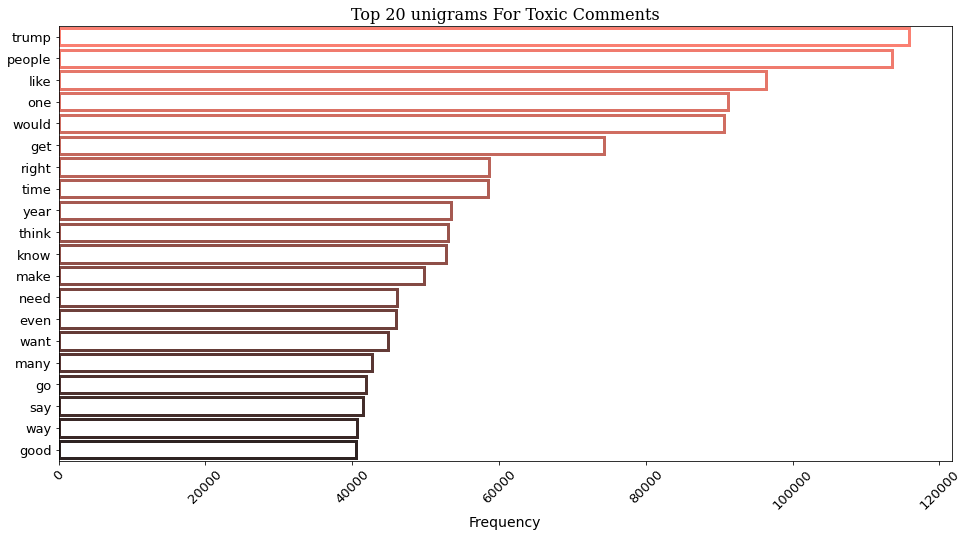

In [10]:
common_words_toxic_df1 = DataFrame(common_words_toxic,columns=['word','freq'])
plt.figure(figsize=(16, 8))
ax = sns.barplot(x='freq', y='word', data=common_words_toxic_df1,facecolor=(0, 0, 0, 0),linewidth=3,edgecolor=sns.color_palette("dark:salmon_r",20))

plt.title("Top 20 unigrams For Toxic Comments",font='Serif', fontsize=16)
plt.xlabel("Frequency", fontsize=14)
plt.yticks(fontsize=13)
plt.xticks(rotation=45, fontsize=13)
plt.ylabel("");

In [12]:
common_words_toxic2 = get_top_n_bigram(df_preprocessed.loc[df['target'] > 0, 'comment_preprocessed'].apply(lambda x: np.str_(x)), 20)

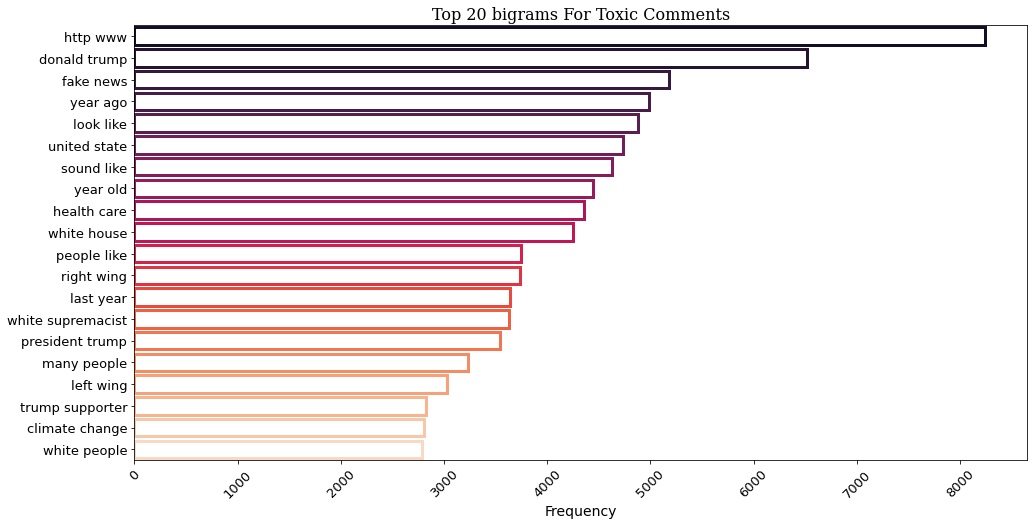

In [13]:
common_words_toxic_df2 = DataFrame (common_words_toxic2,columns=['word','freq'])
plt.figure(figsize=(16,8))
sns.barplot(x='freq', y='word', data=common_words_toxic_df2,facecolor=(0, 0, 0, 0),linewidth=3,edgecolor=sns.color_palette("rocket",20))
plt.title("Top 20 bigrams For Toxic Comments",font='Serif', fontsize=16)
plt.xlabel("Frequency", fontsize=14)
plt.yticks(fontsize=13)
plt.xticks(rotation=45, fontsize=13)
plt.ylabel("");

## 2.3 Top 100 unigrams word cloud 

### 2.3.1 On all comments

### At first, we tried to create the word cloud with 1.8 million comment records, however, it turned out to be highlt computationally expensive and we decided to draw a word cloud based on the top 100 words only.

In [19]:
common_words_100 = get_top_n_words(df_preprocessed["comment_preprocessed"].apply(lambda x: np.str_(x)), 100)

position 1
position 2
position 3
position 4
position 5


In [20]:
common_words_100_df = DataFrame(common_words_100,columns=['word','freq'])

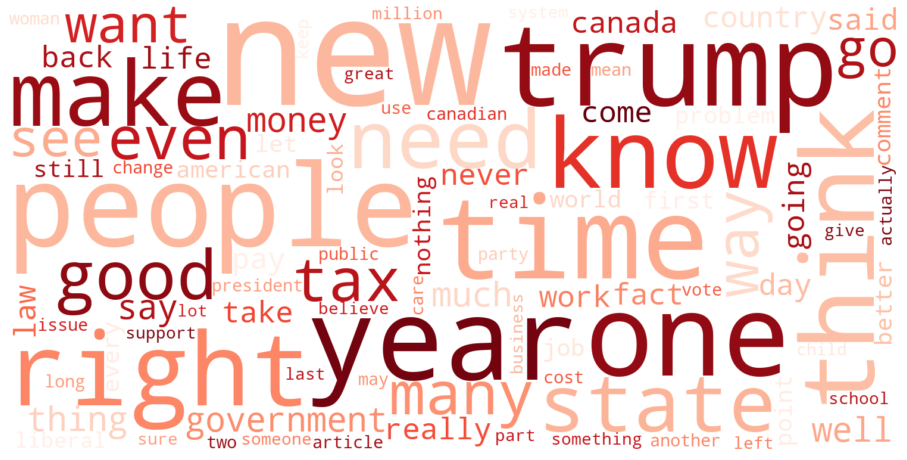

In [21]:
plt.subplots(figsize=(16,16))
wc = WordCloud(stopwords=STOPWORDS,background_color="white", contour_width=2, colormap='Reds_r',width=1500, height=750,max_words=150, max_font_size=256,random_state=42)
i = 0
text = ""
for comment in common_words_100_df['word']:
    text += str(comment)+' '
wc.generate(text)
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

### 2.3.2 On toxic comments

In [22]:
common_words_100_toxic = get_top_n_words(df_preprocessed.loc[df['target'] > 0, 'comment_preprocessed'].apply(lambda x: np.str_(x)), 100)

position 1
position 2
position 3
position 4
position 5


In [25]:
common_words_100_toxic_df = DataFrame(common_words_100_toxic,columns=['word','freq'])

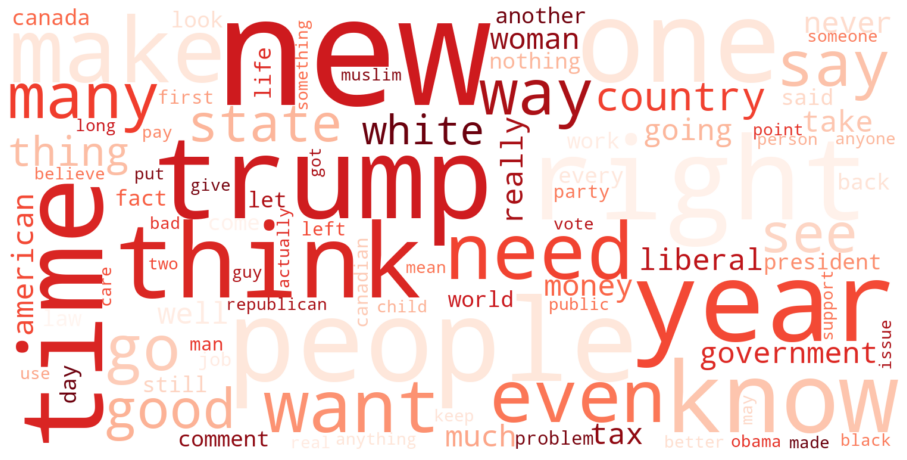

In [26]:
plt.subplots(figsize=(16,16))
wc = WordCloud(stopwords=STOPWORDS,background_color="white", contour_width=2, colormap='Reds',width=1500, height=750,max_words=150, max_font_size=256,random_state=42)
i = 0
text = ""
for comment in common_words_100_toxic_df['word']:
    text += str(comment)+' '
wc.generate(text)
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

In [52]:
# retrieve the comments that meet the conditions
comments = df_preprocessed.loc[(df_preprocessed['target'] == 1.0) & (df_preprocessed['comment_preprocessed'].str.contains('trump')), 'comment_text']

In [54]:
for text in comments:
    print(f"comment: {text}")
    print()

comment: Marlene Pearson, do you really think Trump or Sanders will be "waving his arms, scowling, yelling “stupid,” etc. when dealing with heads of state?  I don't think so. Right now they are campaigning.

And, if your worried about choices, what about the city councilors who run unopposed?!

comment: Because donald trump is a hateful windbag with old family money; Obama earned his way into the presidency within the law.

comment: Of such ignorant (legislature) proposals are born Trumps.....

comment: 4) Donald Trump, delusional megalomaniac.

comment: No, she was the one who said this, "Looking at a young black woman in the group, I told her: 'I would rather be a black man in America than a black woman in Africa.' ”

The black woman said nothing in reply, but there was an acknowledgment in her eyes that she had heard me. Had she wanted to, I have no doubt that she was capable of responding on her own.?" 

This is found documented in her article, "Young Facists COLONIZE PORTLAND"

Sh

## 2.4 Part of Speech Tagging

In [35]:
df_preprocessed['pos_tags'] = df_preprocessed['comment_preprocessed'].apply(lambda x: np.str_(x)).str.split().map(pos_tag)

def count_tags(pos_tags):
    tag_count = {}
    for word,tag in pos_tags:
        if tag in tag_count:
            tag_count[tag] += 1
        else:
            tag_count[tag] = 1
    return tag_count

df_preprocessed['tag_counts'] = df_preprocessed['pos_tags'].map(count_tags)

In [38]:
set_pos = set([tag for tags in df_preprocessed['tag_counts'] for tag in tags])
tag_cols = list(set_pos)

for tag in tag_cols:
    df_preprocessed[tag] = df_preprocessed['tag_counts'].map(lambda x: x.get(tag, 0))

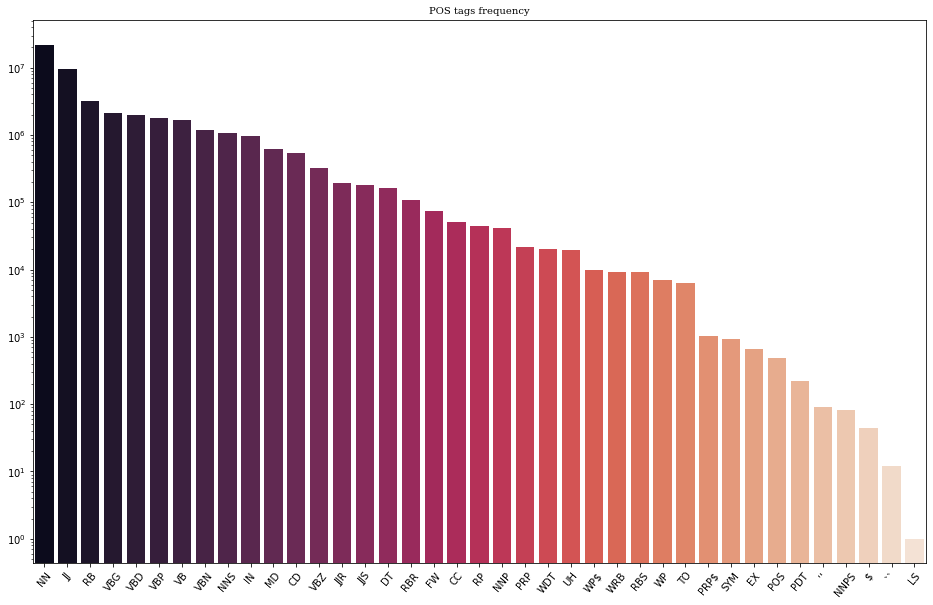

In [41]:
pos = df_preprocessed[tag_cols].sum().sort_values(ascending = False)
plt.figure(figsize=(16,10))
ax = sns.barplot(x=pos.index, y=pos.values,palette="rocket")
plt.xticks(rotation = 50)
ax.set_yscale('log')
plt.title('POS tags frequency',fontsize=20,font="Serif")
plt.show()

### Nouns, adjectives, past tense verb and adverbs are more frequently used in the comments.

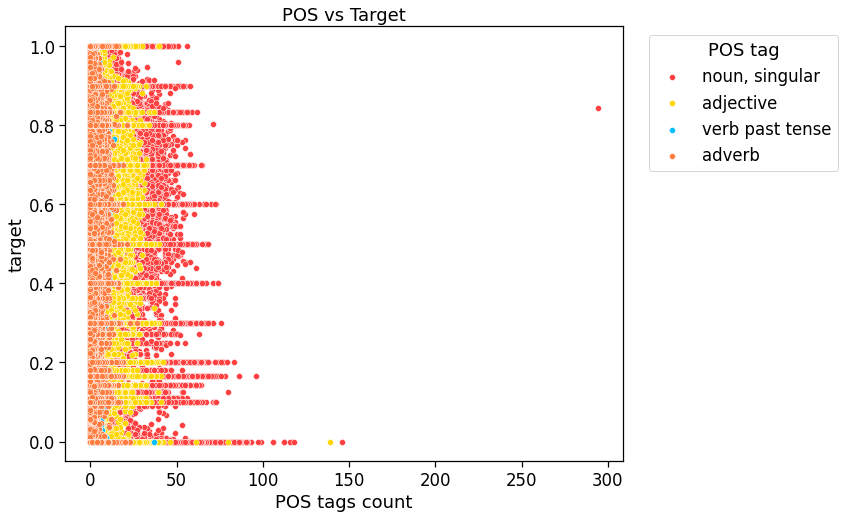

In [47]:
plt.figure(figsize=(10,8))
sns.scatterplot(data=df_preprocessed,x='NN',y='target',color= '#FF4040',markers='.',label="noun, singular")
sns.scatterplot(data=df_preprocessed,x='JJ',y='target',color= '#FFD700',markers='.',label="adjective",)
sns.scatterplot(data=df_preprocessed,x='VBD',y='target',color= '#00BFFF',markers='.',label="verb past tense")
sns.scatterplot(data=df_preprocessed,x='RB',y='target',color= '#FF7D40',markers='.',label="adverb")
plt.legend(title="POS tag",bbox_to_anchor=(1.4, 1))
plt.xlabel("POS tags count")
plt.title("POS vs Target")
plt.show()

### As we tried to draw the scatte plot between pos tage counts and target scores, we found out there is an outlier which may influence the way we evaluate the rest of the distributions. Thus we decided to draw another scatter plot without this outlier.

In [49]:
# Create a copy of the original dataframe
new_df = df_preprocessed.copy()

In [52]:
# Find the index of the row with the maximum value of 'NN' key in the 'tag_counts' column
max_index = new_df['tag_counts'].apply(lambda x: x.get('NN', 0)).argmax()

In [53]:
# Remove the row with the max 'NN' value
new_df = new_df.drop(max_index)

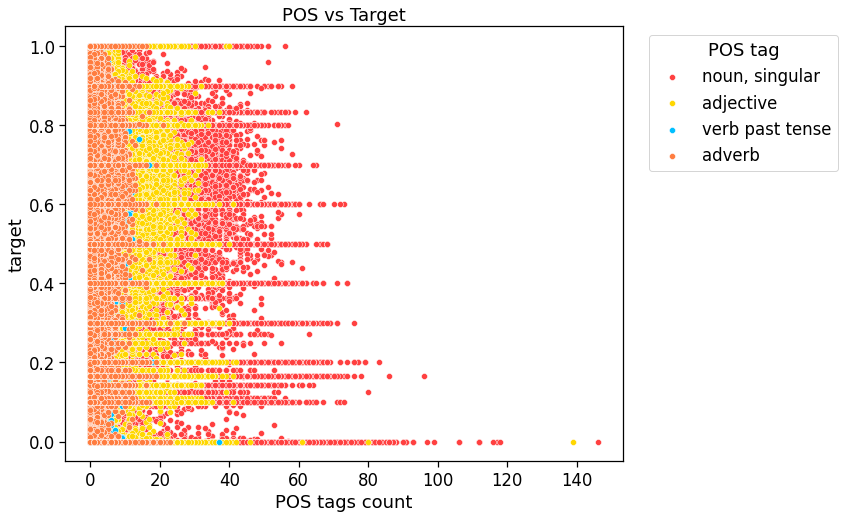

In [54]:
plt.figure(figsize=(10,8))
sns.scatterplot(data=new_df,x='NN',y='target',color= '#FF4040',markers='.',label="noun, singular")
sns.scatterplot(data=new_df,x='JJ',y='target',color= '#FFD700',markers='.',label="adjective",)
sns.scatterplot(data=new_df,x='VBD',y='target',color= '#00BFFF',markers='.',label="verb past tense")
sns.scatterplot(data=new_df,x='RB',y='target',color= '#FF7D40',markers='.',label="adverb")
plt.legend(title="POS tag",bbox_to_anchor=(1.4, 1))
plt.xlabel("POS tags count")
plt.title("POS vs Target")
plt.show()

### Based on the scatter plot, we can see there is not necessarily a big difference among different POS tags with regard to the target score. All categories of POS tags have a full range of target scores from the lowest to the highest.

In [56]:
# Select rows where 'target' column is not equal to 0
new_df = new_df[new_df['target'] != 0]

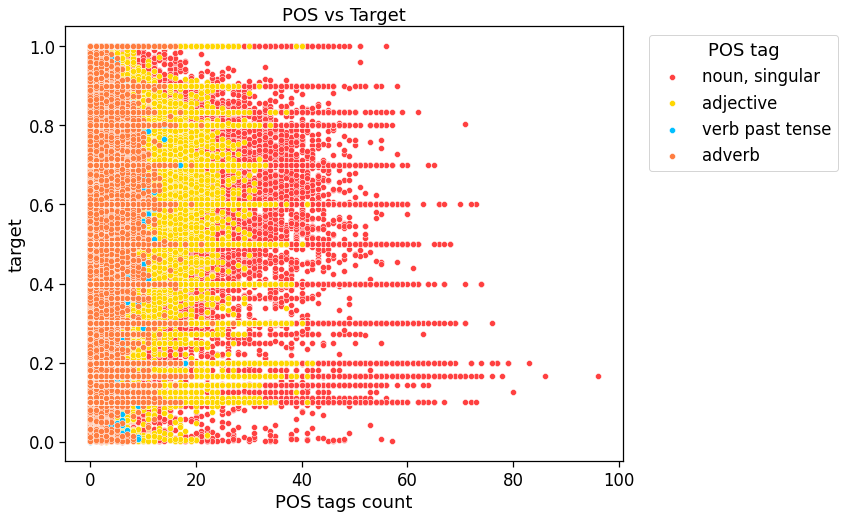

In [57]:
plt.figure(figsize=(10,8))
sns.scatterplot(data=new_df,x='NN',y='target',color= '#FF4040',markers='.',label="noun, singular")
sns.scatterplot(data=new_df,x='JJ',y='target',color= '#FFD700',markers='.',label="adjective",)
sns.scatterplot(data=new_df,x='VBD',y='target',color= '#00BFFF',markers='.',label="verb past tense")
sns.scatterplot(data=new_df,x='RB',y='target',color= '#FF7D40',markers='.',label="adverb")
plt.legend(title="POS tag",bbox_to_anchor=(1.4, 1))
plt.xlabel("POS tags count")
plt.title("POS vs Target")
plt.show()

### Based on the scatter plot which filtered comments with toxicity only, we can see there is not necessarily a big difference among different POS tags with regard to the target score either. All categories of POS tags have a full range of target scores from the lowest to the highest.

### Implications: moving forward, information asscociated with POS tag counts will not be considered into model training

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# Part3: Sentiment Analysis

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

In [62]:
# Instantiate a SentimentIntensityAnalyzer object from VADER
sia = SentimentIntensityAnalyzer()

In [65]:
# Apply the polarity_scores() method of the SentimentIntensityAnalyzer object to the 'comment_preprocessed' column
df_preprocessed['sentiment'] = df_preprocessed['comment_preprocessed'].apply(lambda x: np.str_(x)).apply(lambda x: sia.polarity_scores(x))

In [67]:
# Extract the compound score from the sentiment dictionary and create a new column 'compound_sentiment'
df_preprocessed['compound_sentiment'] = df_preprocessed['sentiment'].apply(lambda x: x['compound'])

In [71]:
# Select rows where 'target' column is not equal to 0
df_not0 = df_preprocessed[df_preprocessed['target'] != 0]

/var/folders/4q/v1383t7j6k74mb6zcdqgd4zm0000gn/T/ipykernel_1634/1060889496.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_preprocessed['compound_sentiment'], color=palette[0], shade=True,ax=ax[0])
/var/folders/4q/v1383t7j6k74mb6zcdqgd4zm0000gn/T/ipykernel_1634/1060889496.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_not0['compound_sentiment'], color=palette[1], shade=True,ax=ax[1])


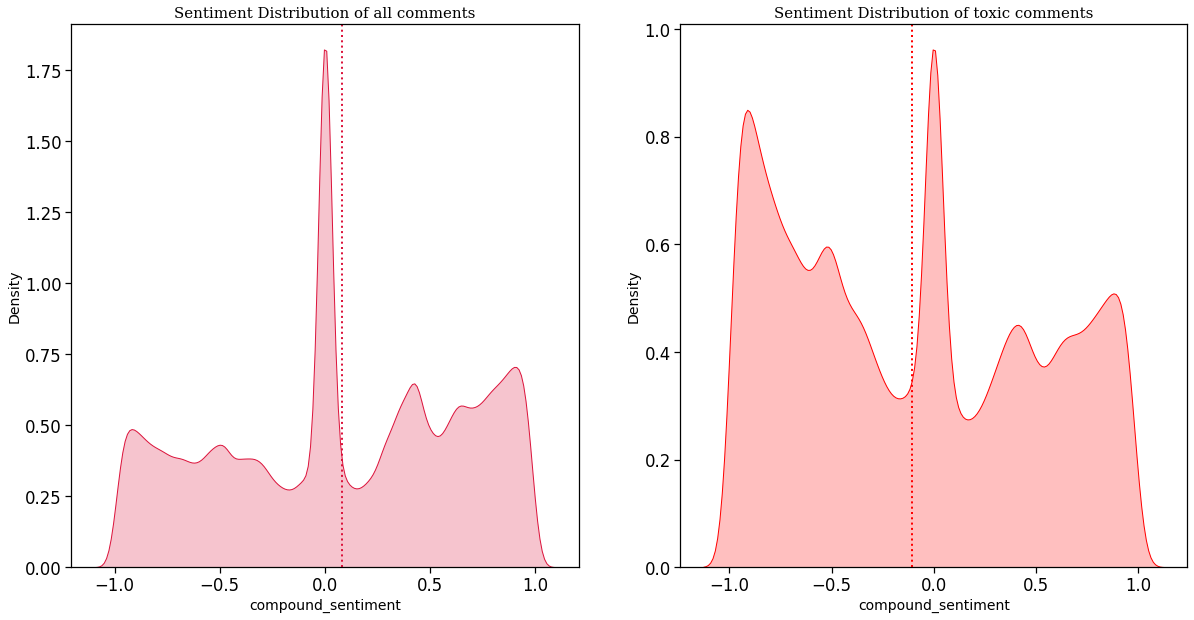

In [72]:
# Distribution plot for Target score and Identity Attack score
fig, ax = plt.subplots(1,2,figsize=(20,10))
sns.kdeplot(df_preprocessed['compound_sentiment'], color=palette[0], shade=True,ax=ax[0])
sns.kdeplot(df_not0['compound_sentiment'], color=palette[1], shade=True,ax=ax[1])
ax[0].axvline(df_preprocessed['compound_sentiment'].mean(), color=palette[0],linestyle=':', linewidth=2)
ax[1].axvline(df_not0['compound_sentiment'].mean(), color=palette[1],linestyle=':', linewidth=2)
ax[0].set_title("Sentiment Distribution of all comments",font="Serif",fontsize = 15)
ax[1].set_title("Sentiment Distribution of toxic comments",font="Serif",fontsize = 15)
plt.show()

### Based on the distribution of sentiment scores of comments, we can tell in general, a high density exists around a relatively neutral score. For toxic comments identified by target score the dataset has, we see a high density existing in negative sentiment side and slightly positive sentiment side. The mean sentiment for toxic comments is also negative.